In [1]:
from typing import Union
import os
import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, SecondLocator, DateFormatter

import plotly.graph_objects as go
import plotly.express as px

import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import scipy

import inference
import learning
import torch

import aeon
import aeon.io.api as api
from aeon.io import reader, video
from aeon.schema.dataset import exp02
from aeon.analysis.utils import visits, distancetravelled
from aeon.io.video import frames

In [2]:
!ls /ceph/aeon

aeon			 aeon_transfer.log  rmhzbm0  test2
aeon_transfer_final.log  db_dumps	    test


In [3]:
# Long, individual session
root = [Path("/ceph/aeon/aeon/data/raw/AEON2/experiment0.2")]

# Ensure root exists
if not np.all([path.exists() for path in root]):
    print("Cannot find root paths. Check path names or connection.")

In [4]:
Exp02Summary = api.load(root, exp02.Metadata).metadata[0].toDict()
Patch_Pos = [device['Regions']['ArrayOfPoint'] for device in Exp02Summary['Devices'] if device['Name'].startswith('ActivityPatch')]

In [5]:
subject_events = api.load(root, exp02.ExperimentalMetadata.SubjectState)
sessions = visits(subject_events[subject_events.id.str.startswith("BAA-")])

# Choose Valid Sessions

In [6]:
sessions_ = sessions.iloc[[4,8,10,11,14,16,17,20,23,24,25,26,28,29,30,31]]
short_sessions = sessions.iloc[[4,16,17,20,23,24,25,26,28,29,30,31]]
long_sessions = sessions.iloc[[8, 10, 11, 14]]

# Check Missing Values

BAA-1100700
BAA-1101818
BAA-1101819
BAA-1101818
BAA-1101818
BAA-1101823
BAA-1101821
BAA-1101819
BAA-1101818
BAA-1101819
BAA-1101818
BAA-1101819


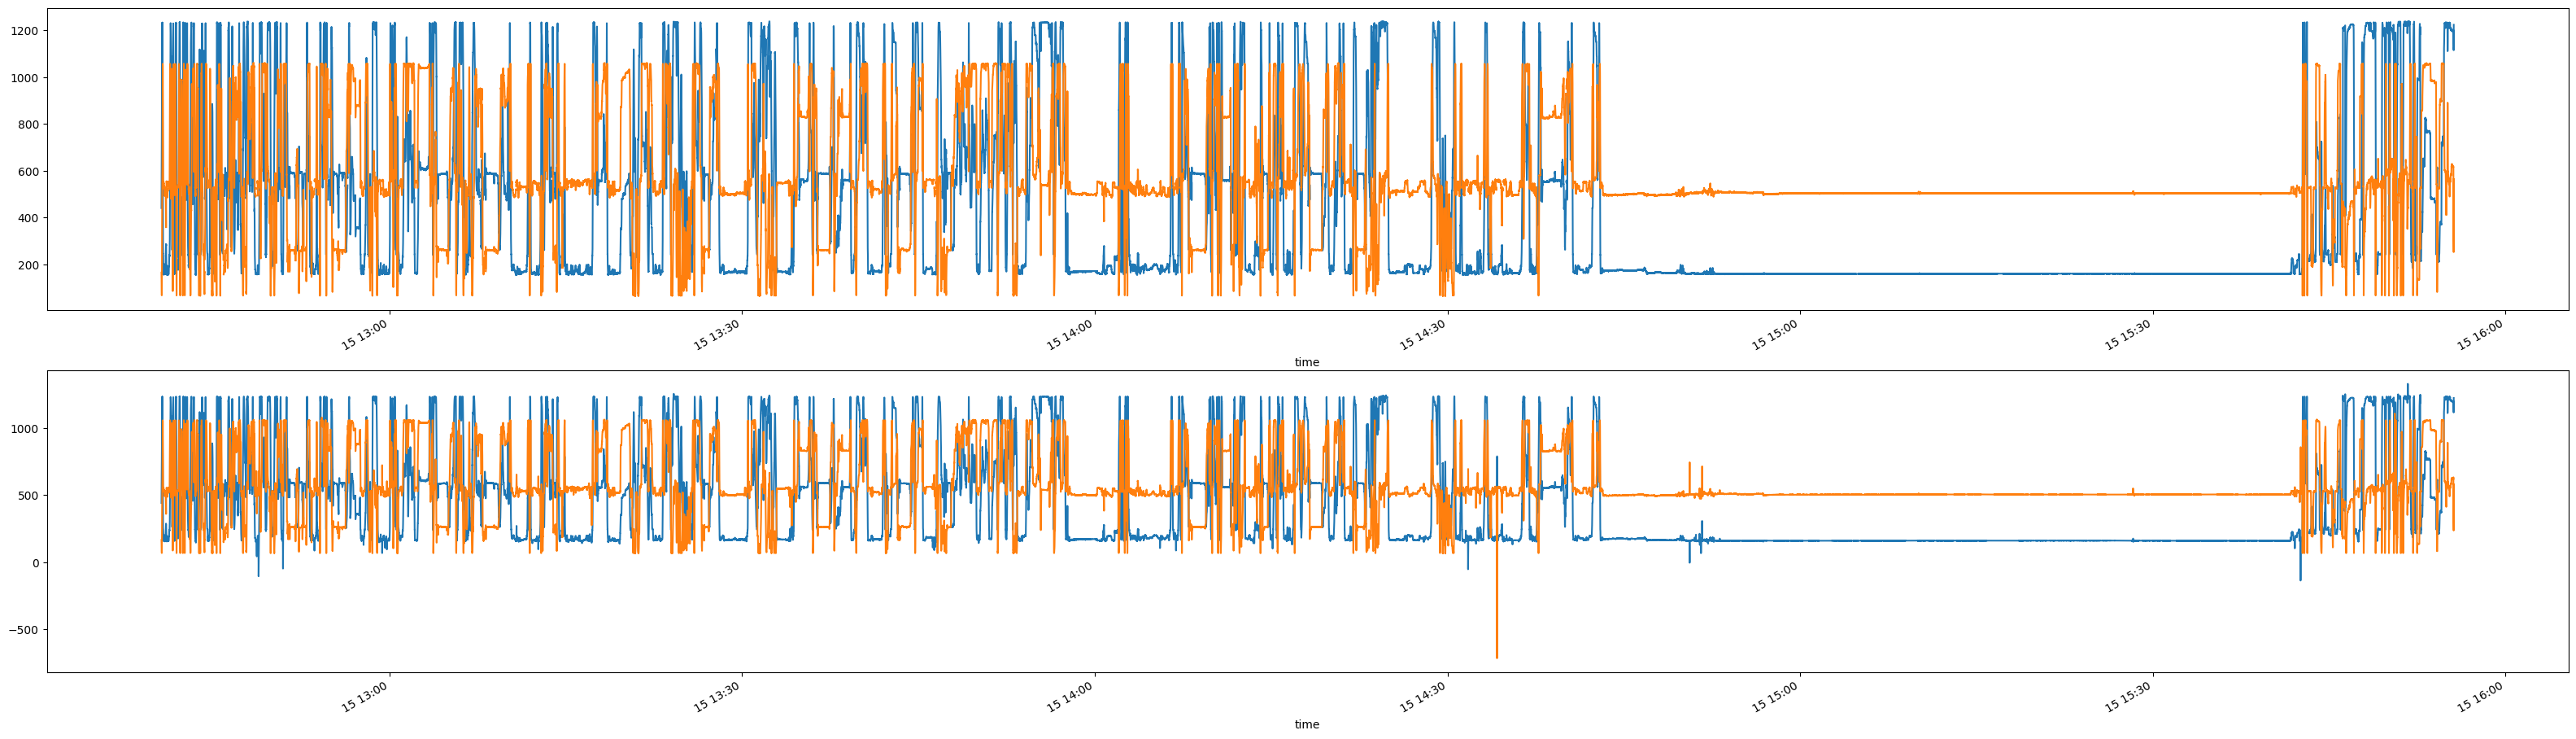

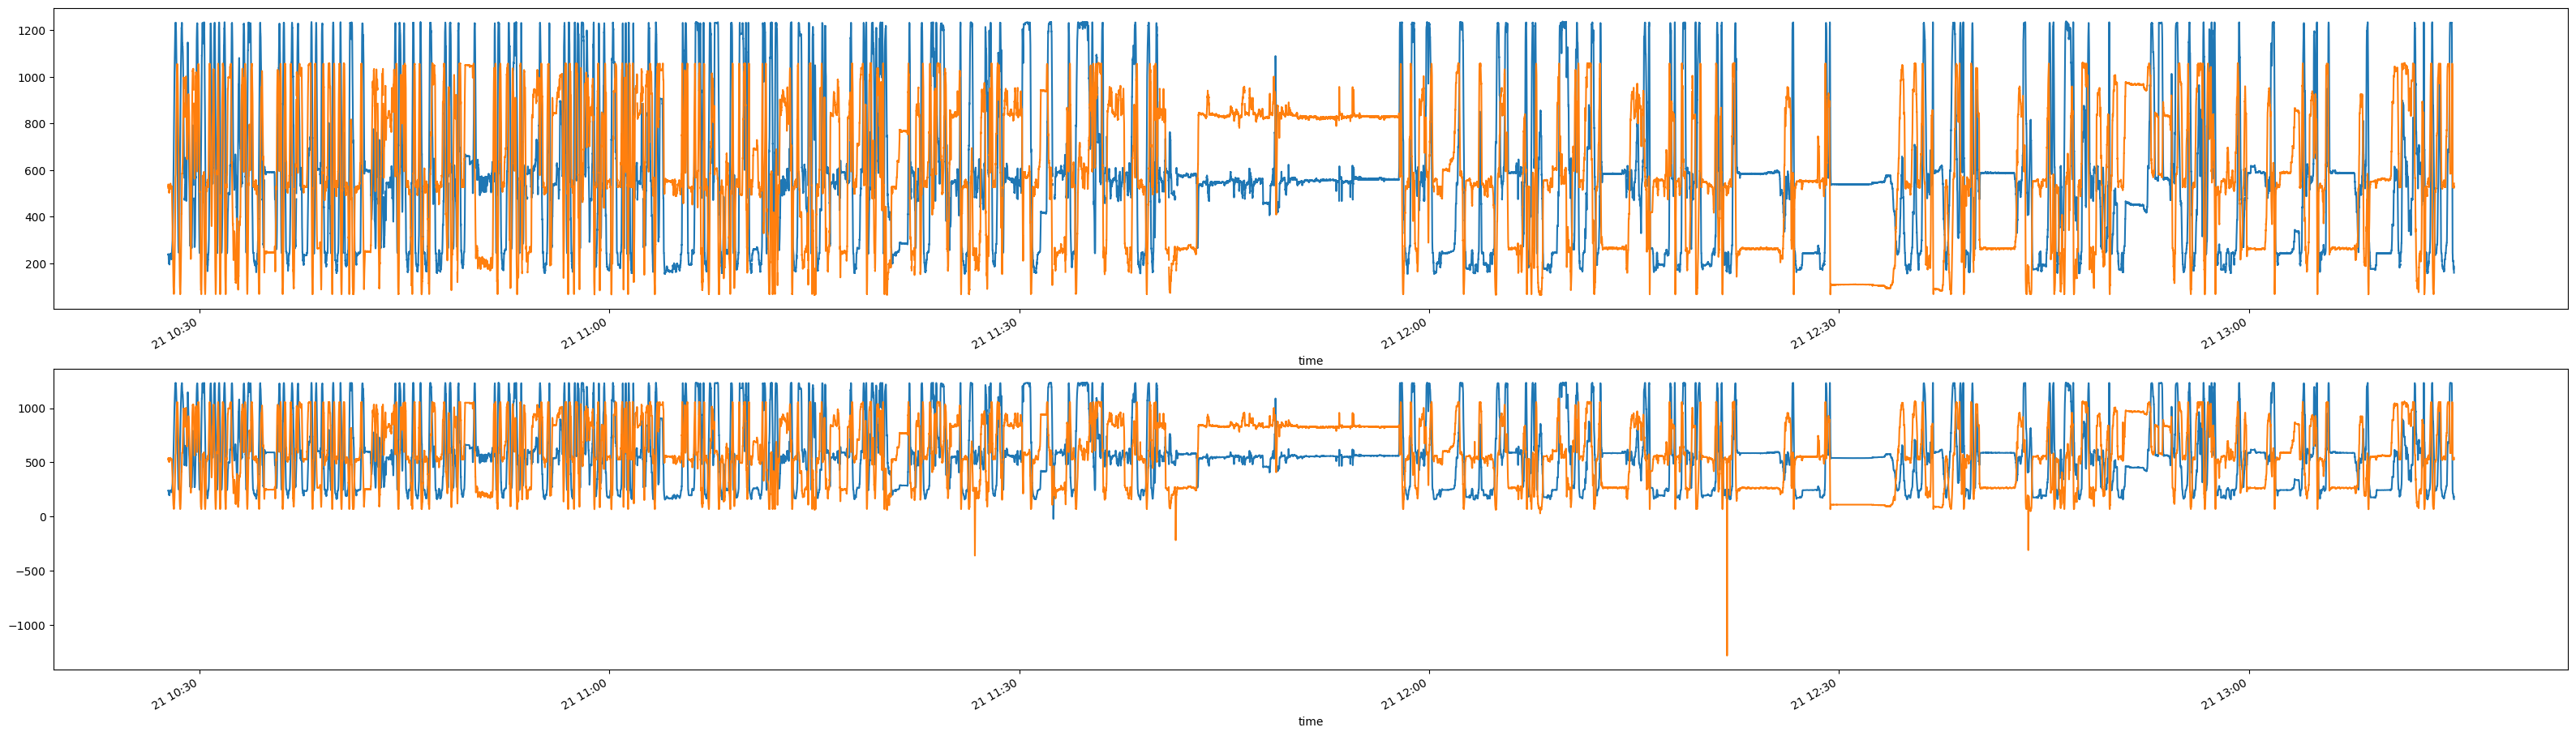

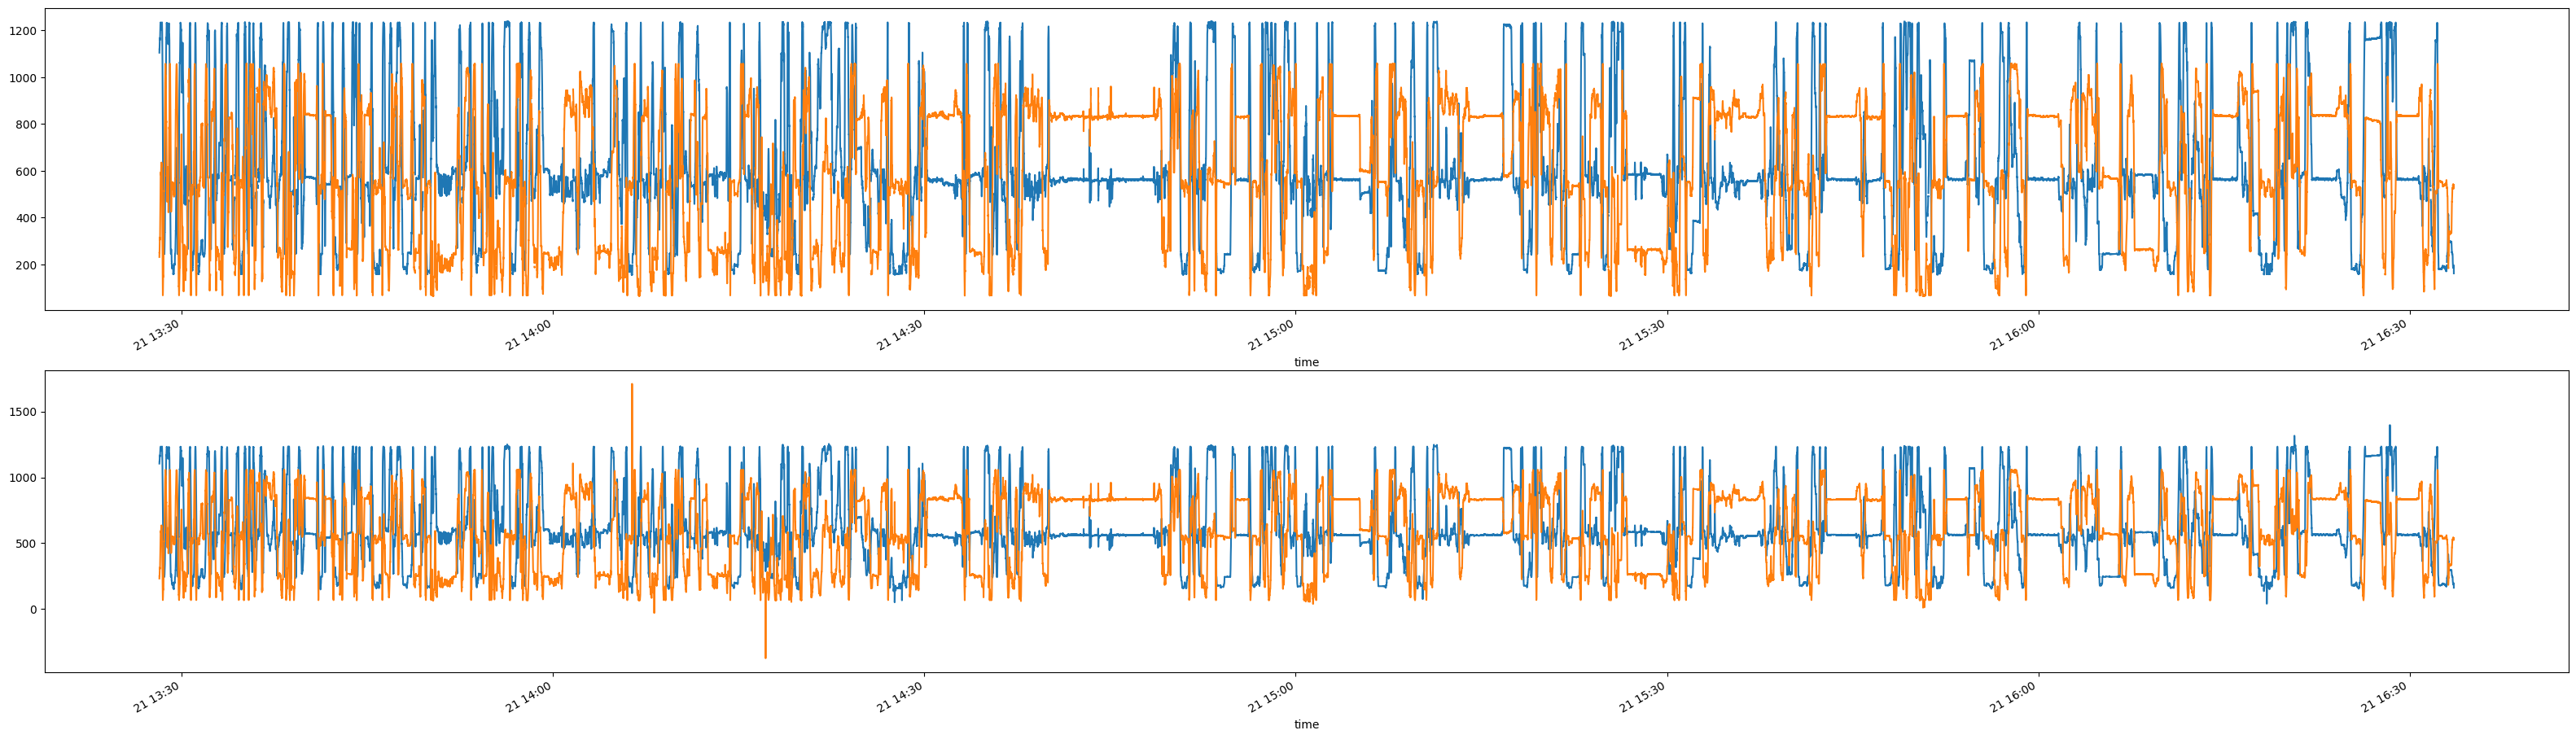

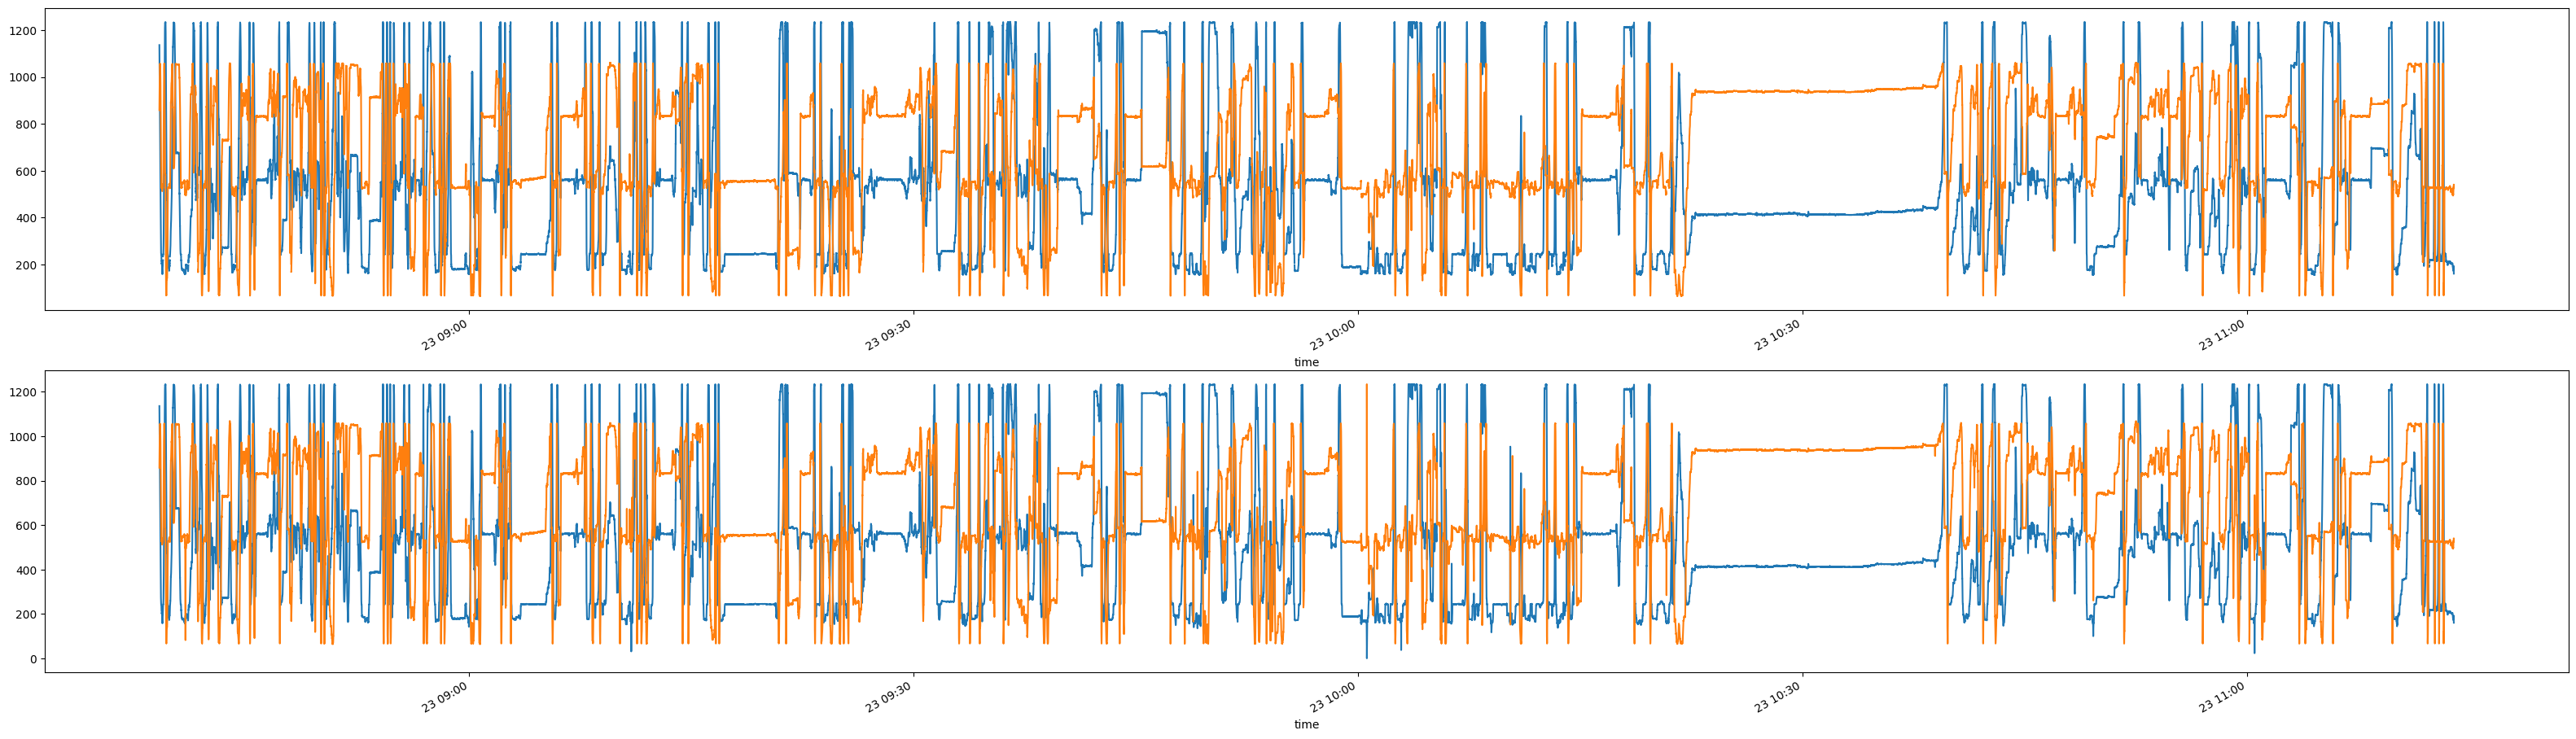

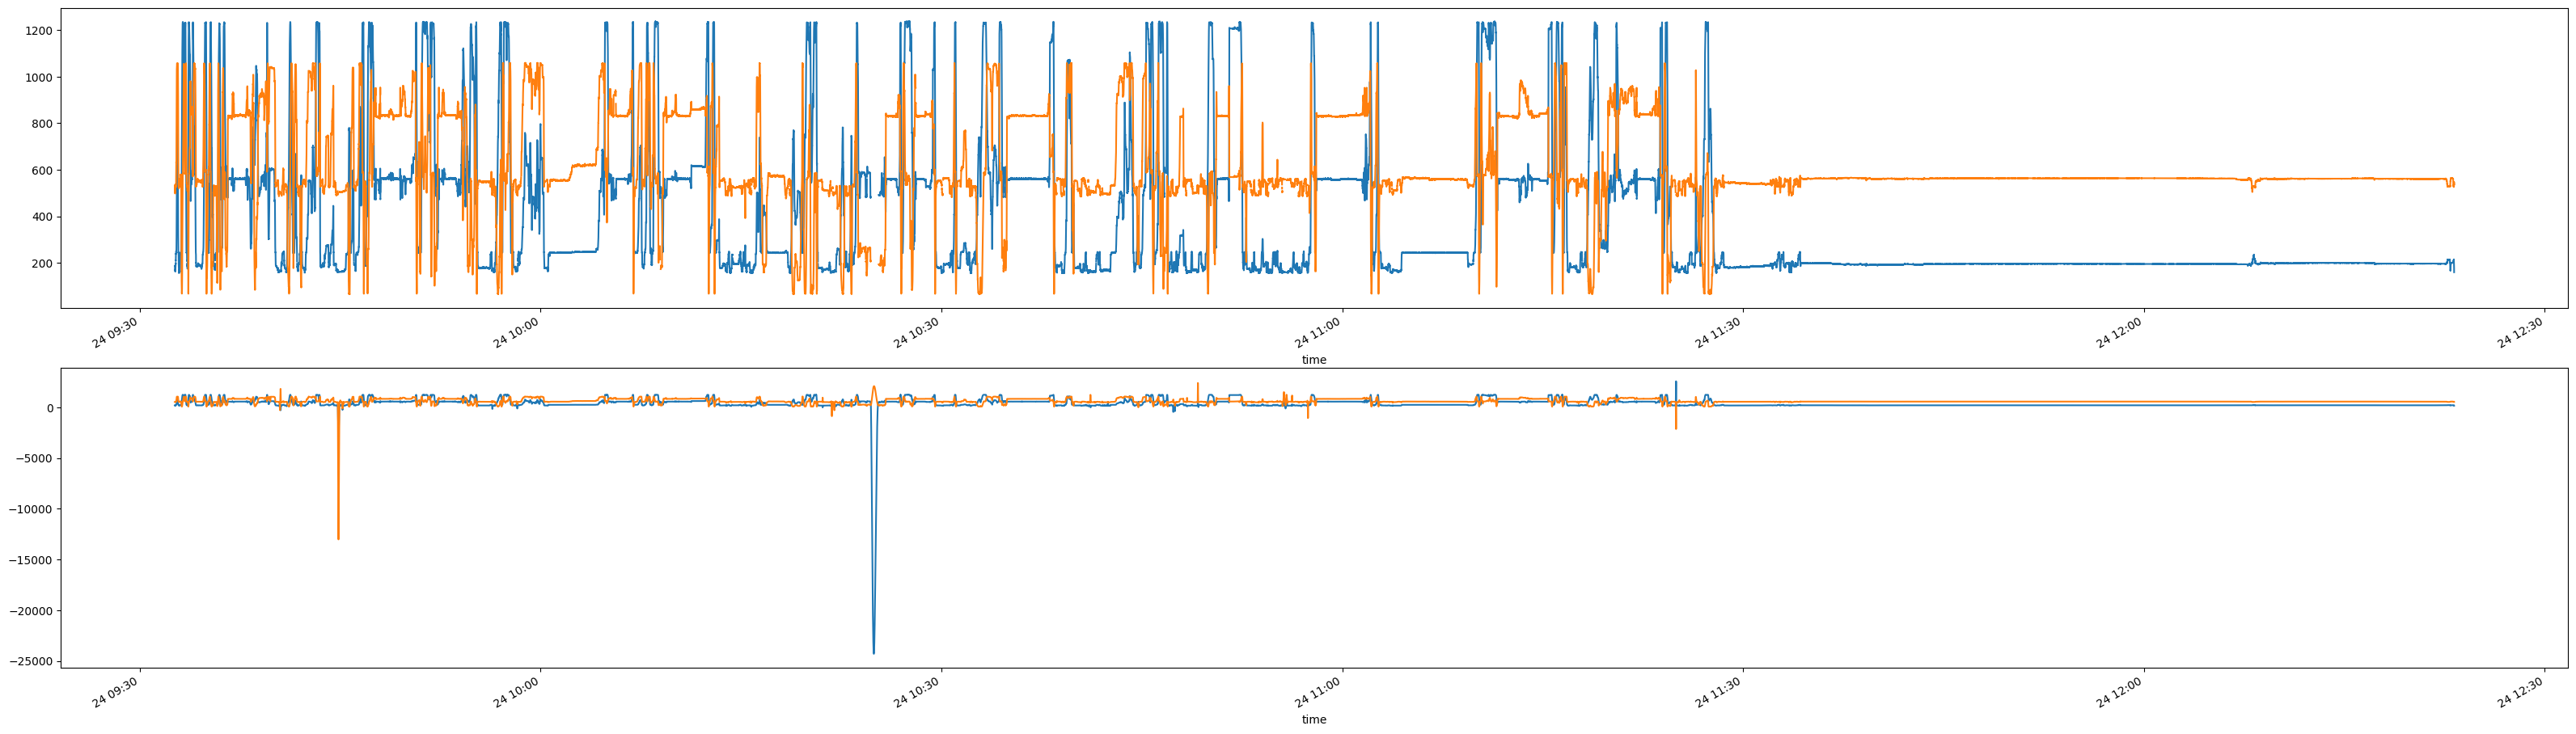

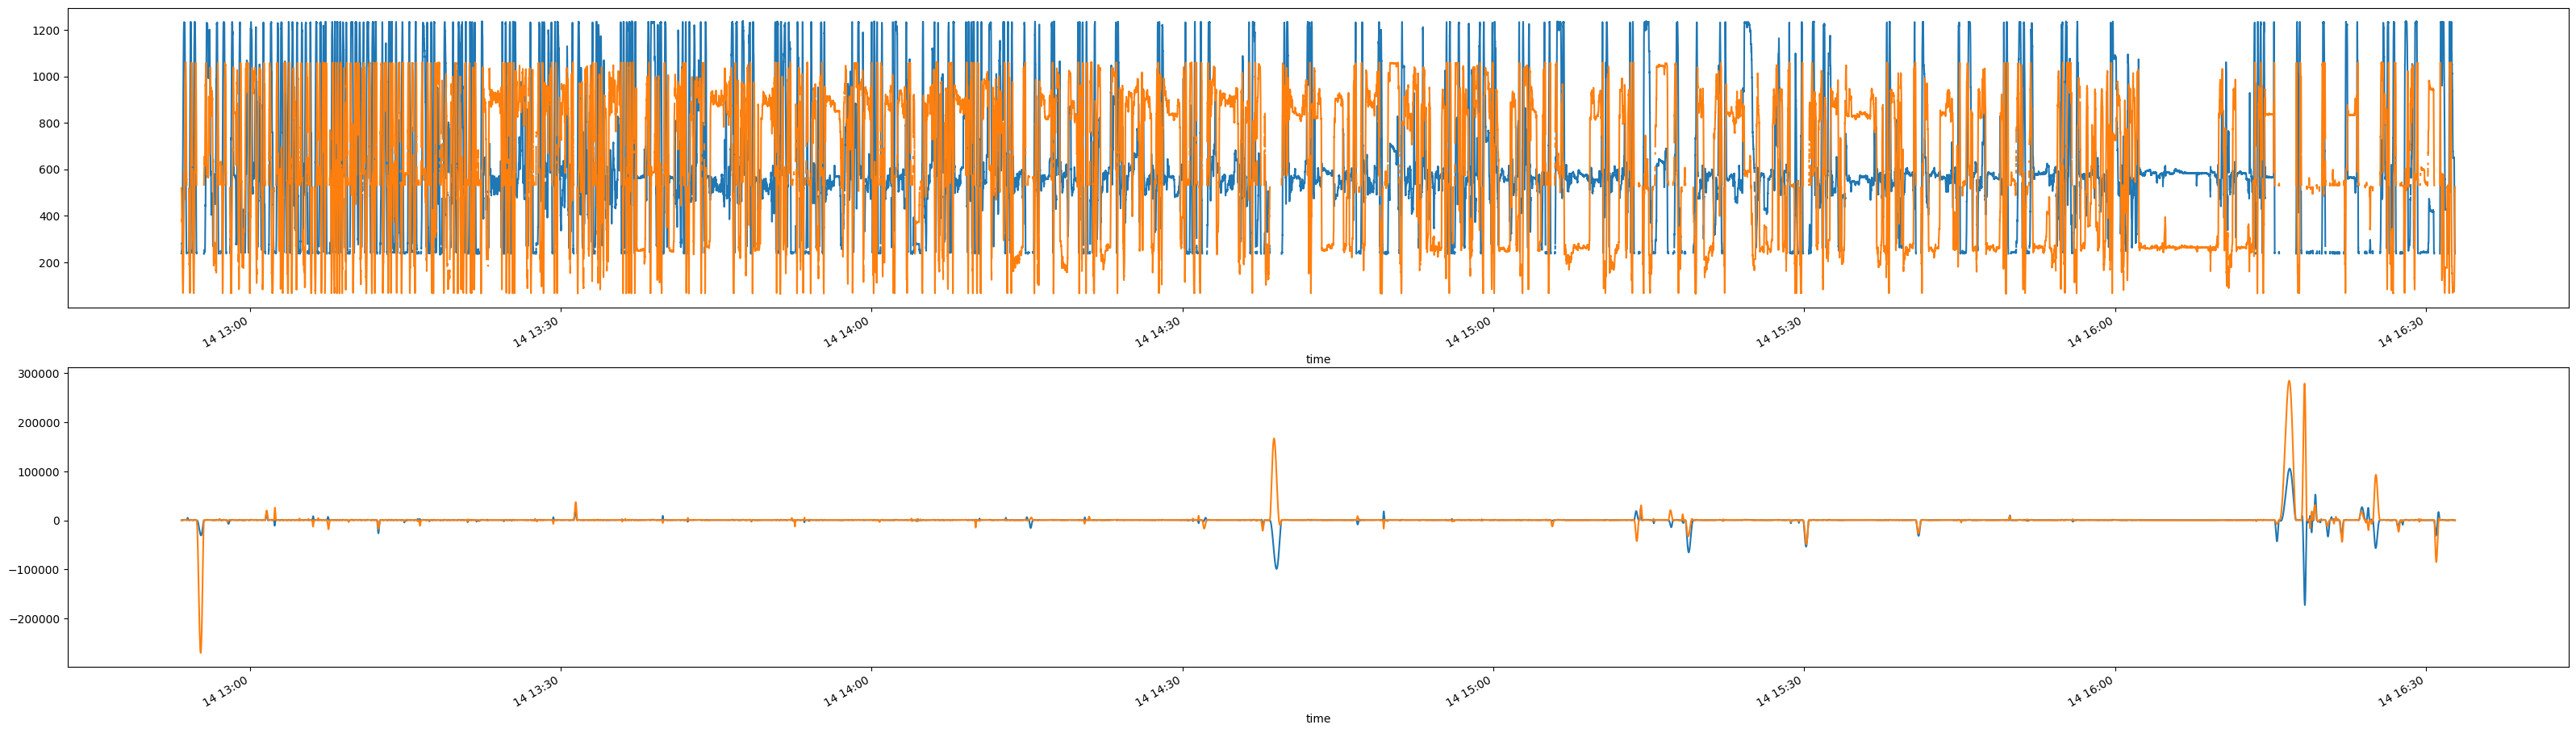

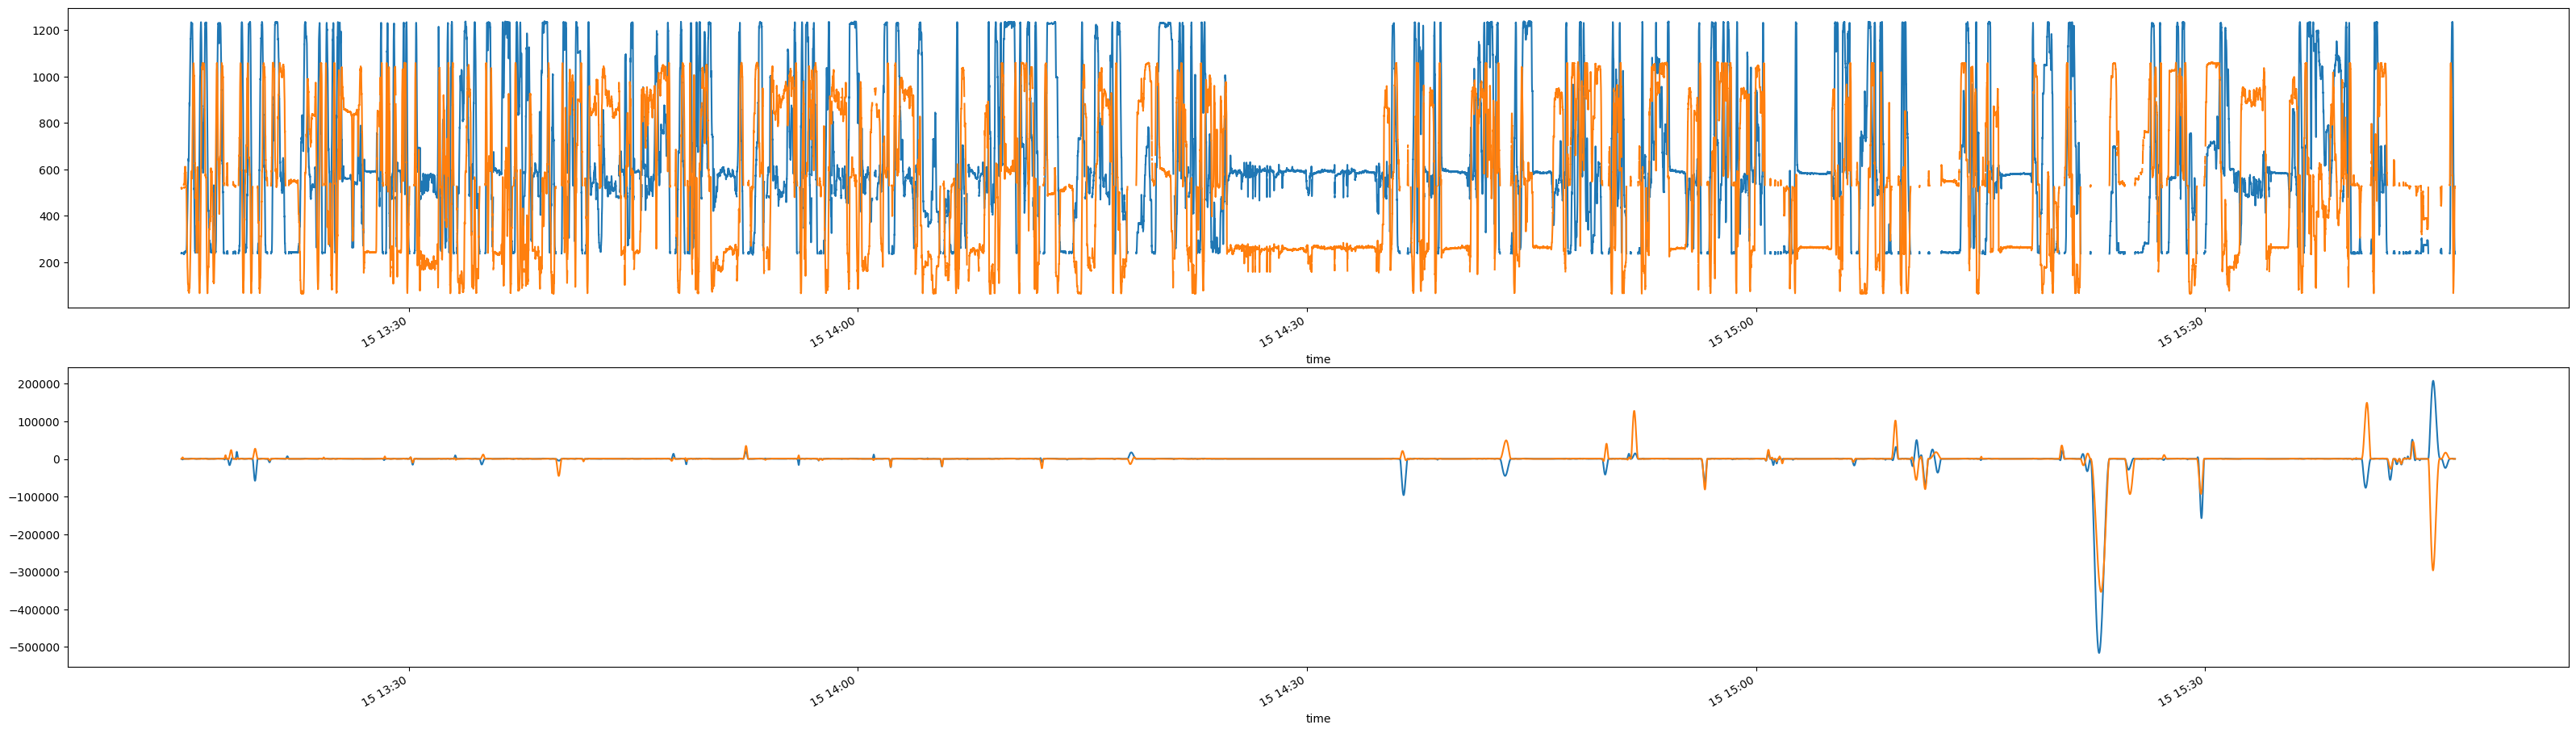

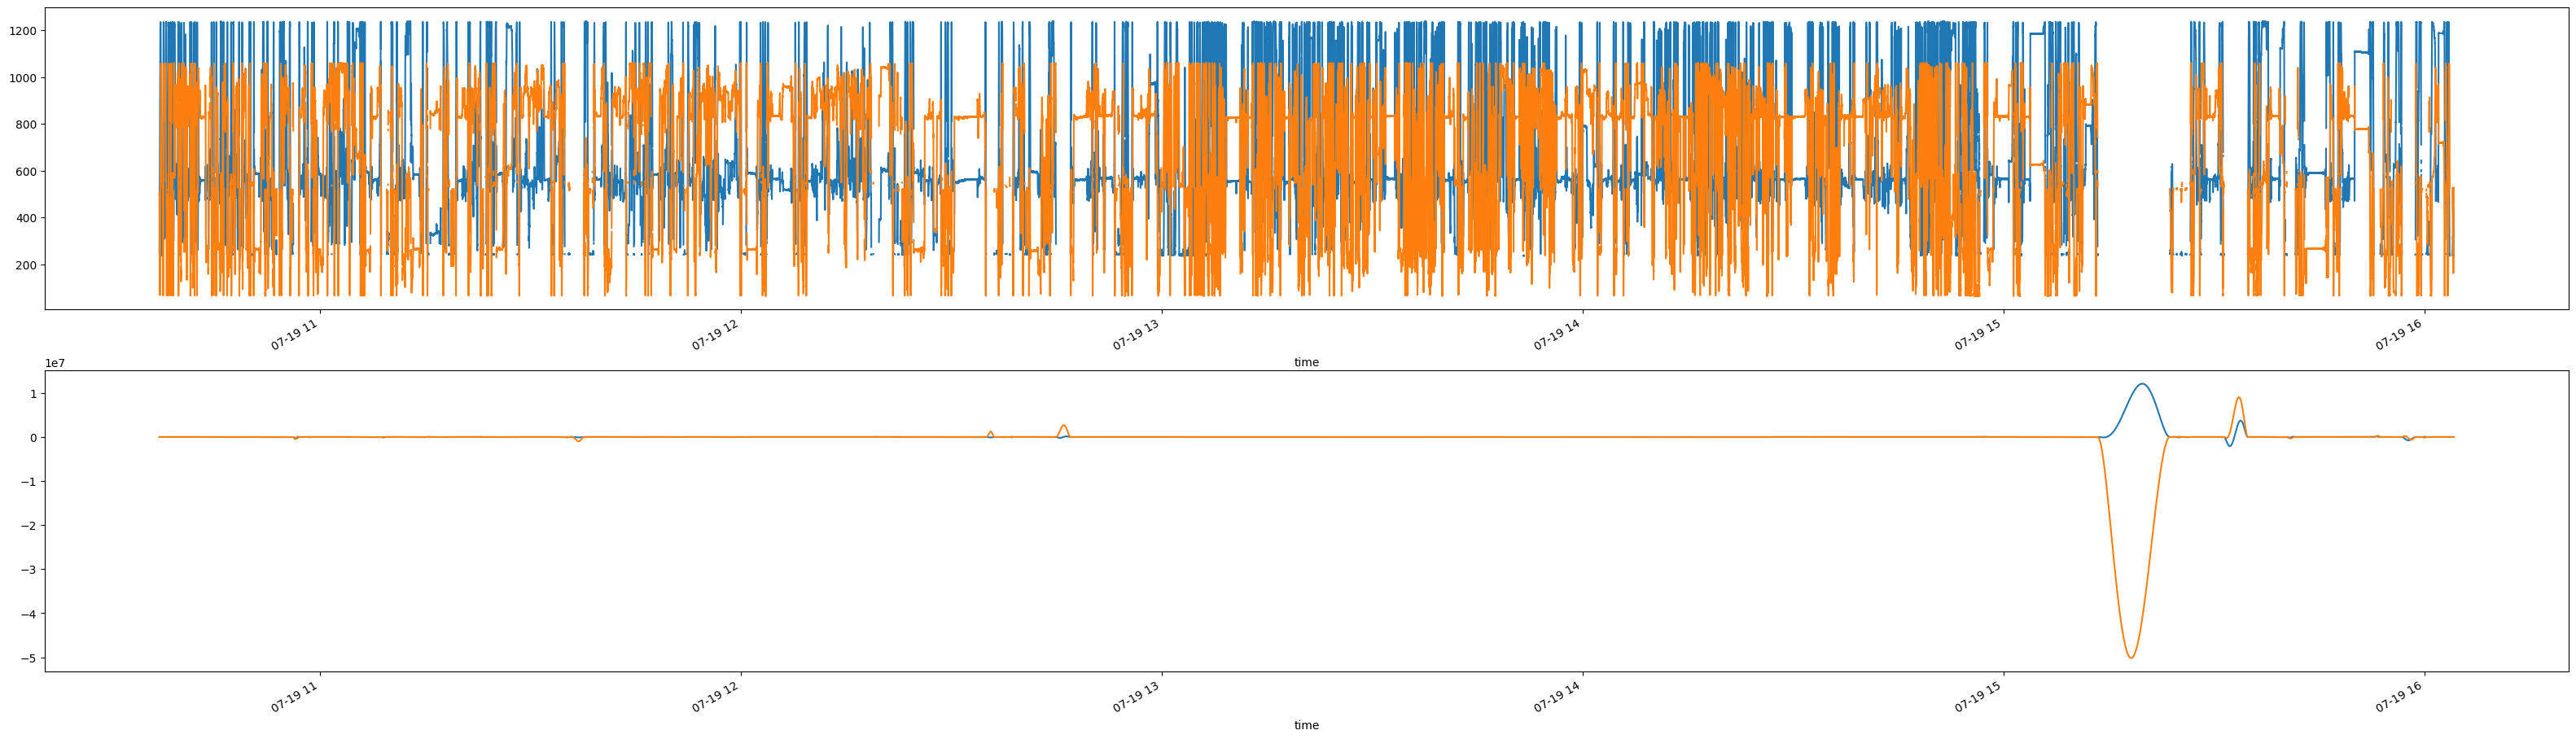

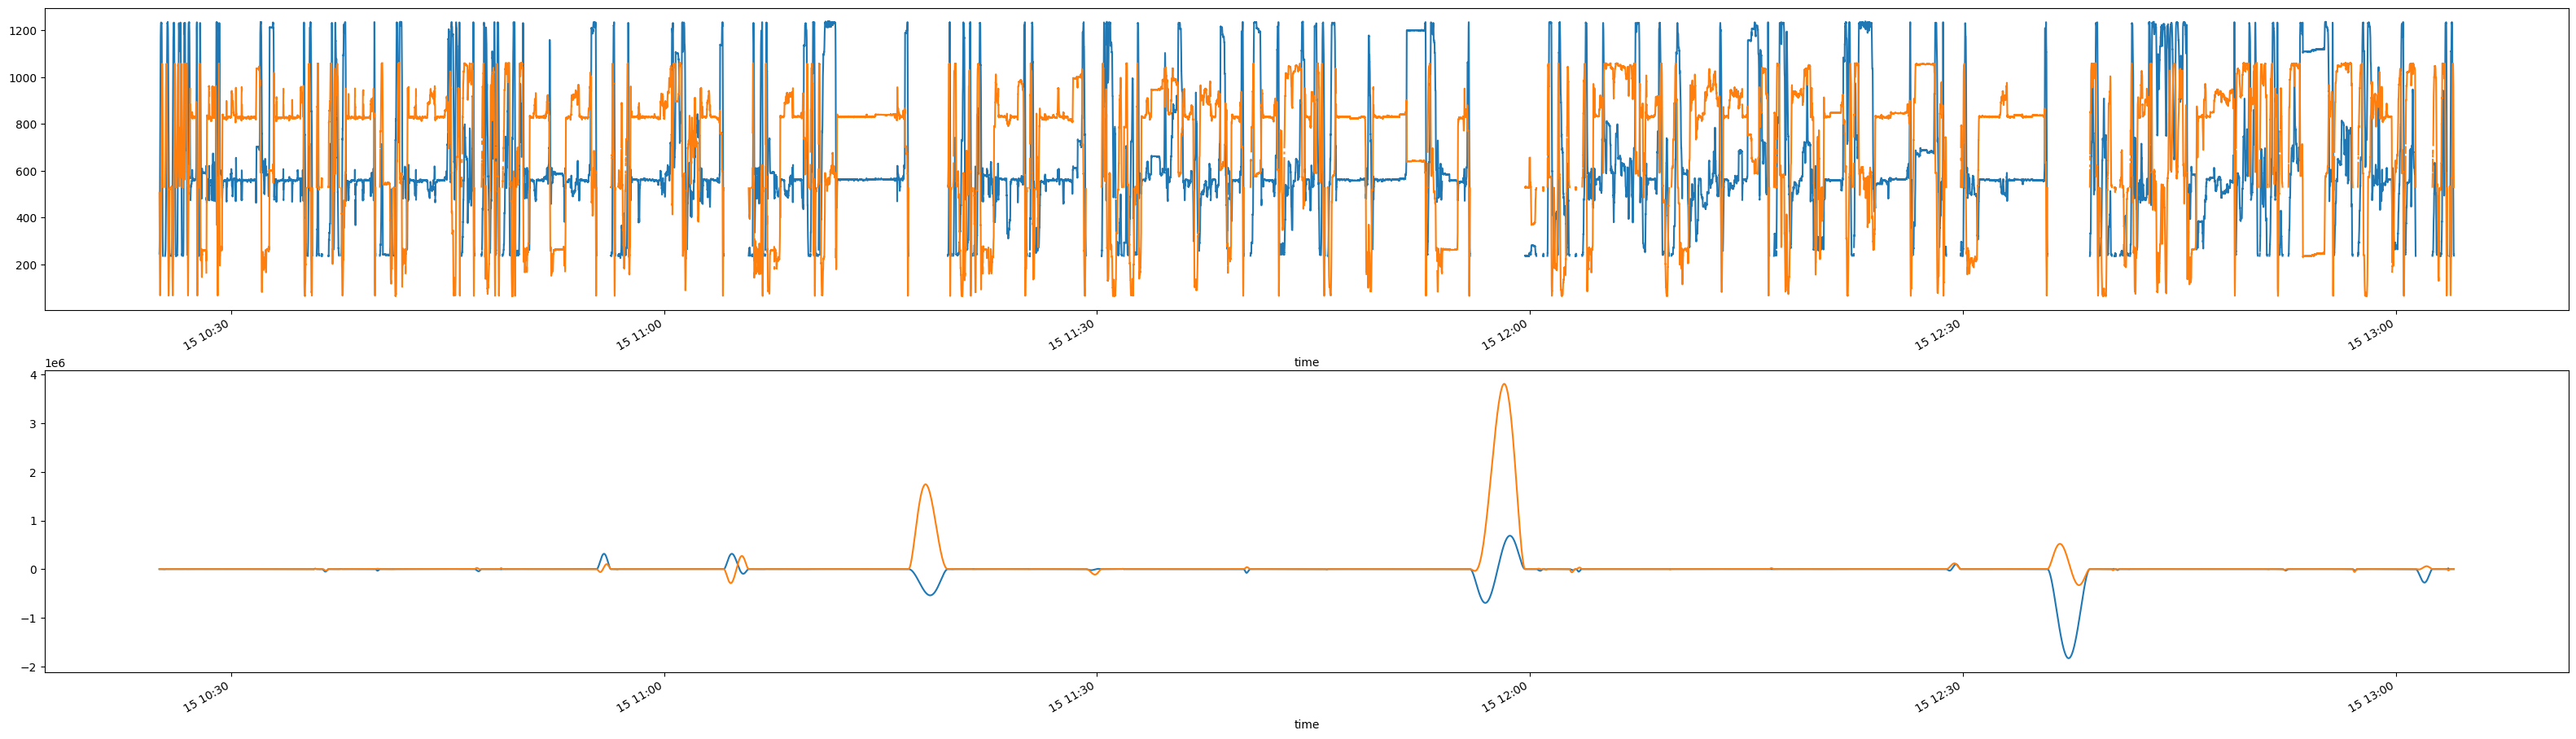

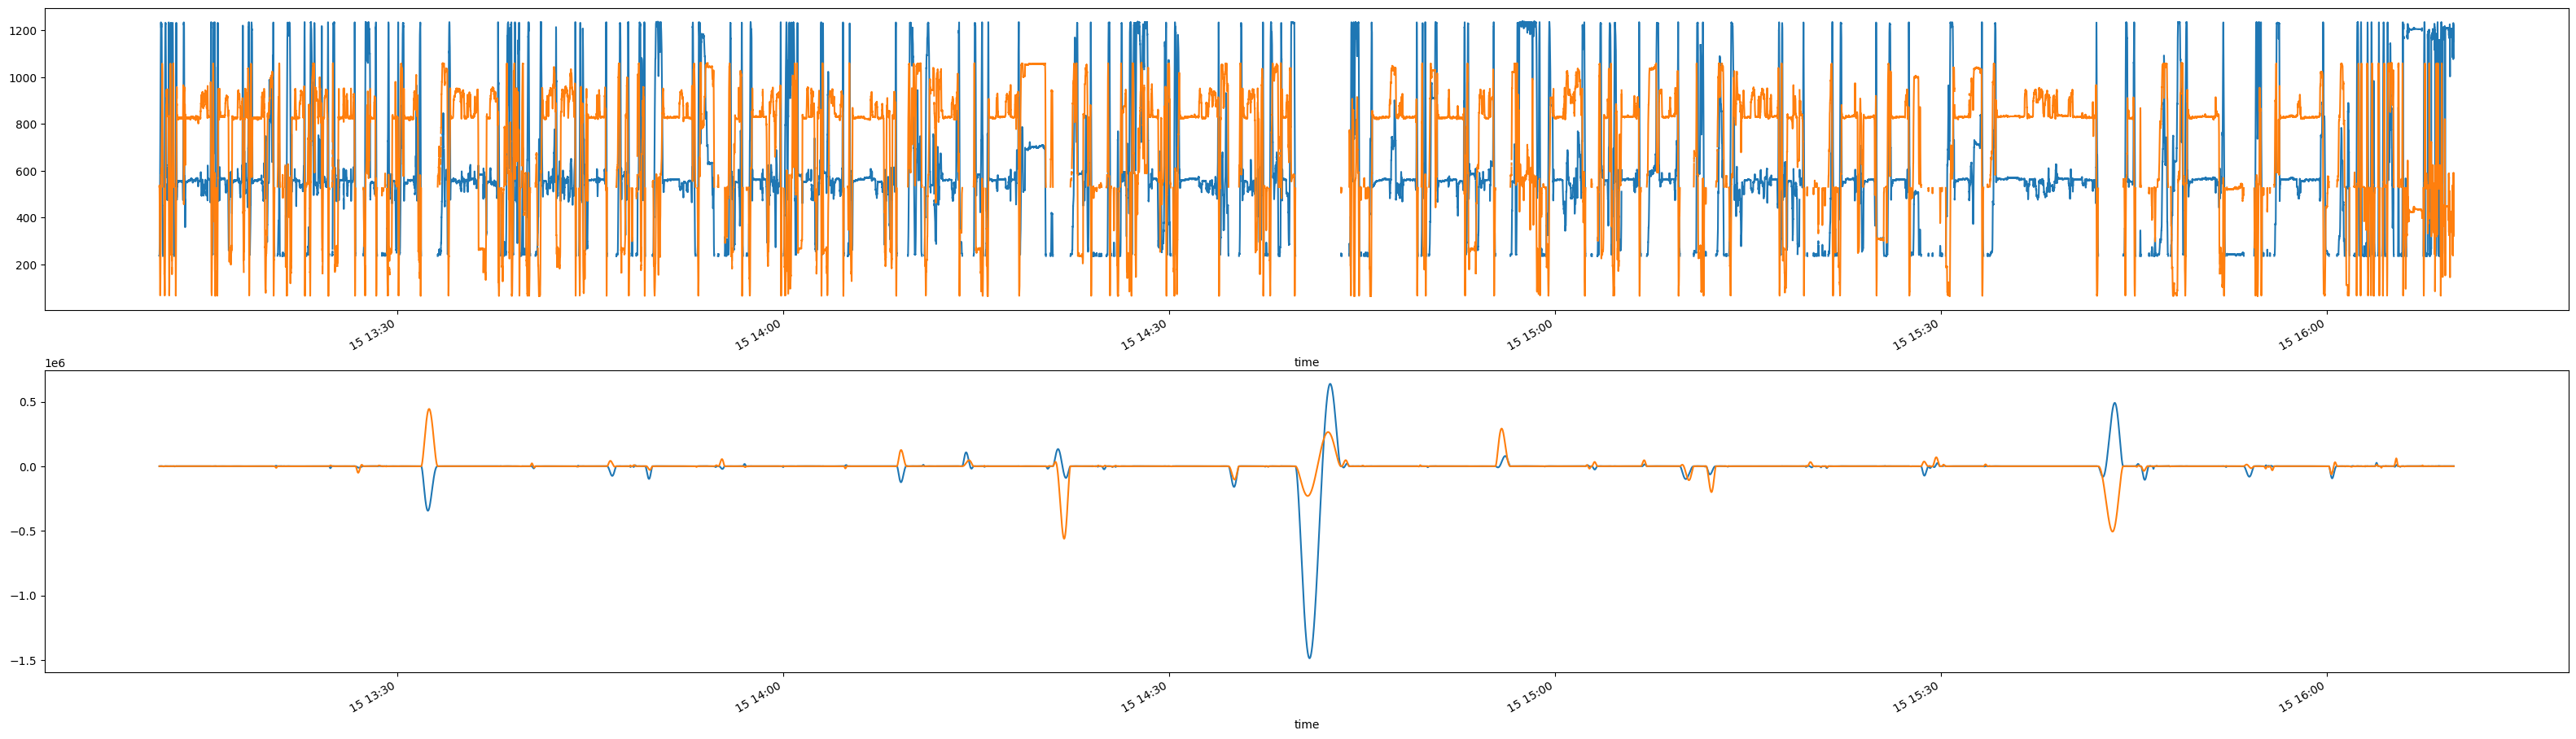

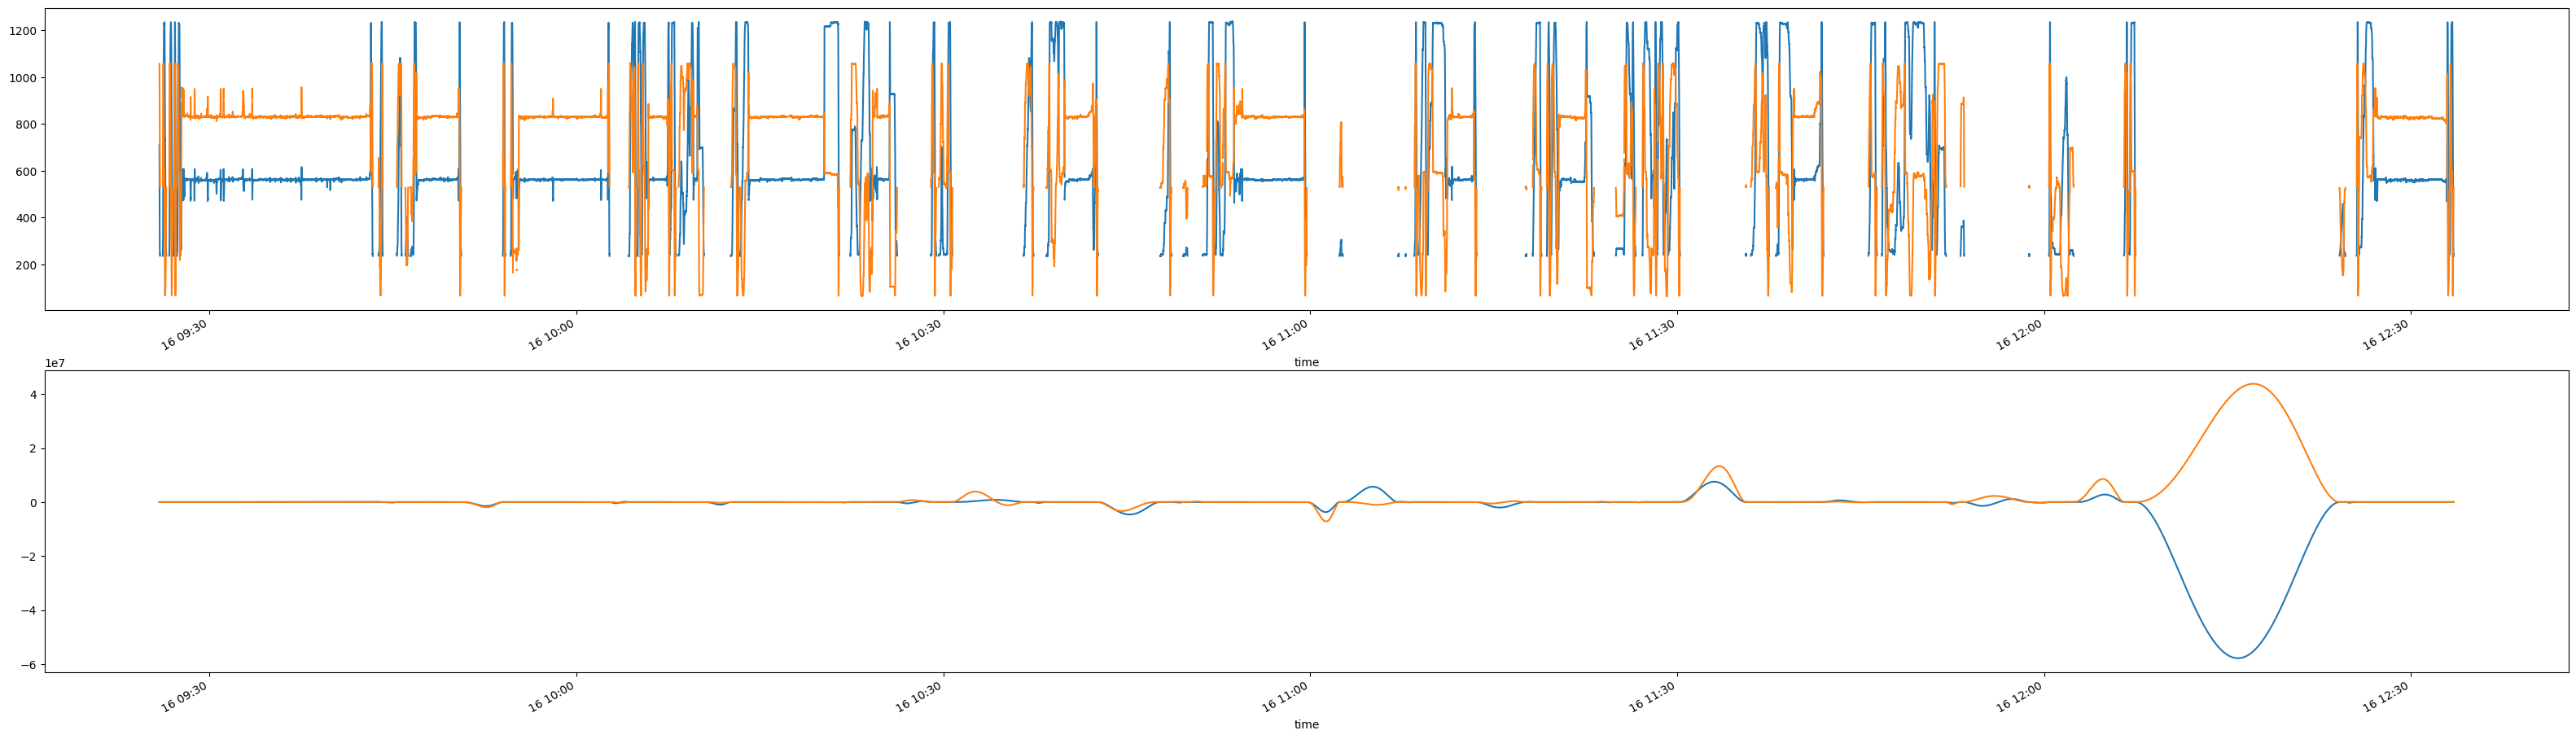

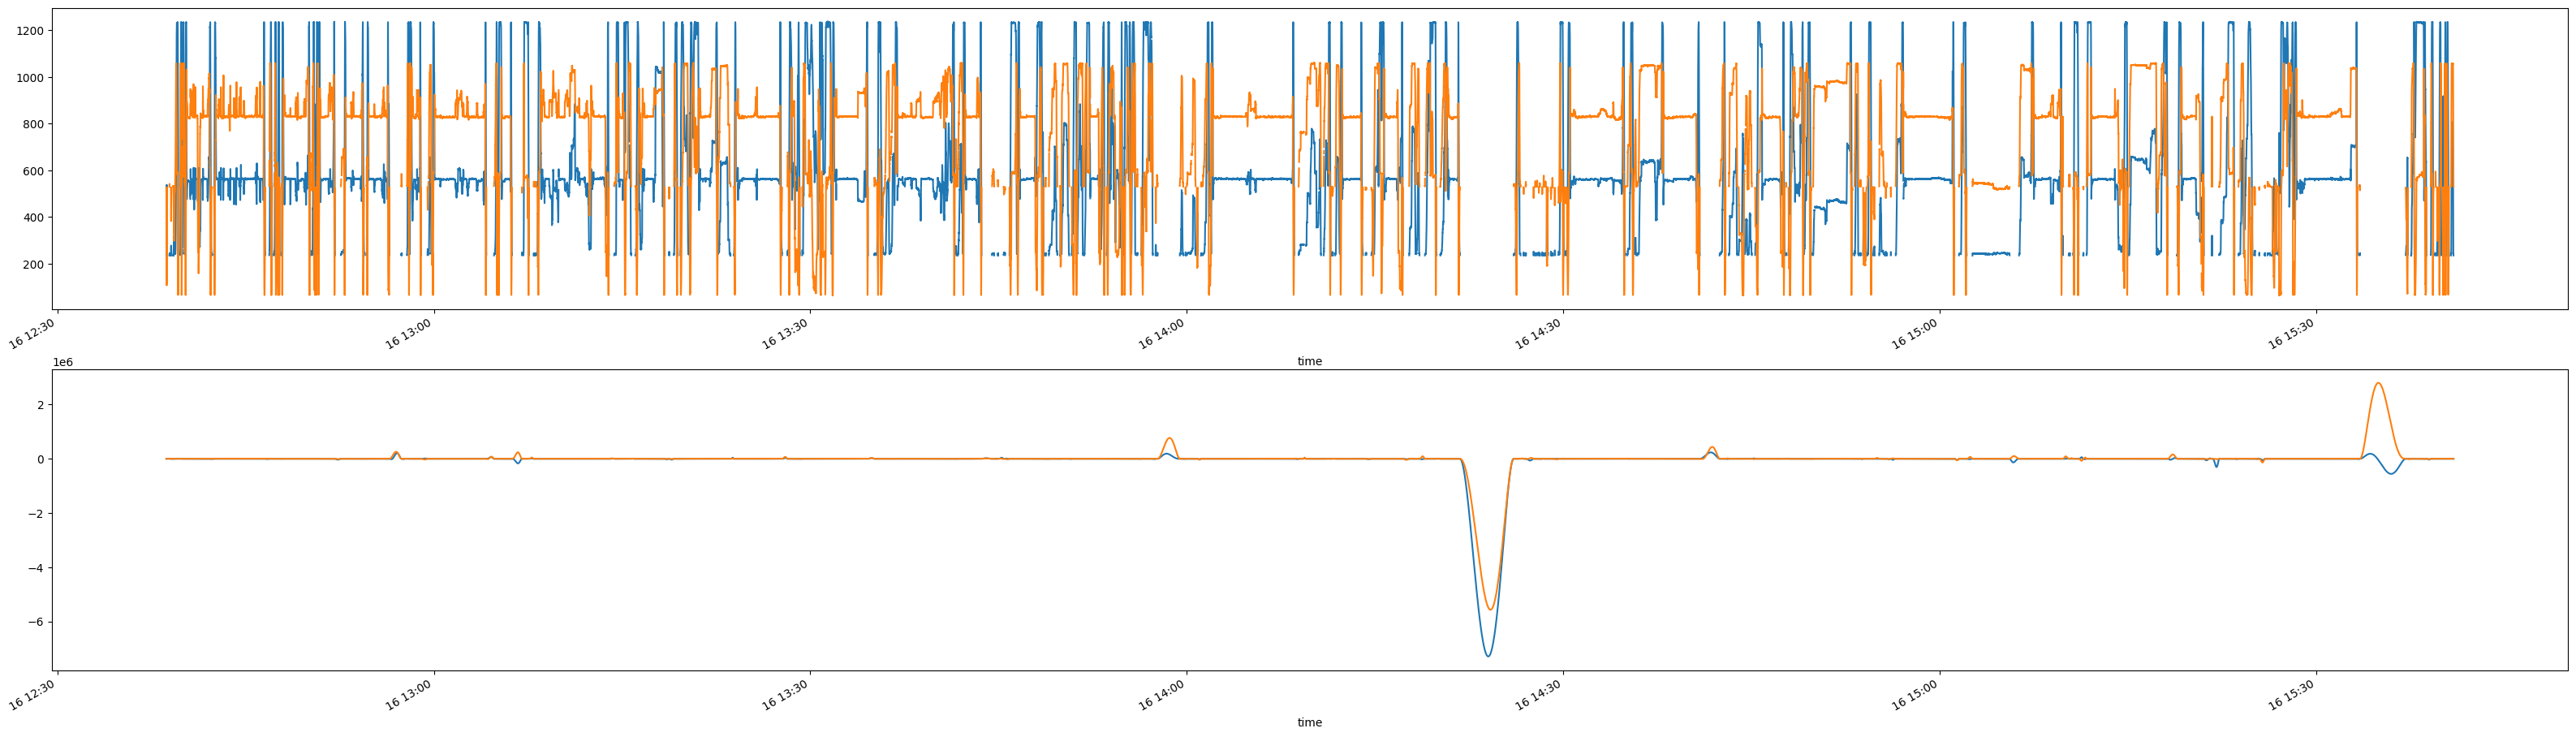

In [11]:
for session, count in zip(list(short_sessions.itertuples()), range(len(short_sessions))):
    print(session.id)
    title = 'ShortSession'+str(count)
    start, end = session.enter, session.exit
    mouse_pos = api.load(root, exp02.CameraTop.Position, start=start, end=end)
    
    temp_df = mouse_pos.dropna(subset=['x', 'y'])
    first_valid_index = temp_df.index[0]
    last_valid_index = temp_df.index[-1]
    mouse_pos = mouse_pos.loc[first_valid_index:last_valid_index]


    smoothRes = np.load(title+'smoothRes.npz')
    mouse_pos['smoothed_position_x_learned'] = pd.Series(smoothRes['xnN'][0][0], index=mouse_pos.index)
    mouse_pos['smoothed_position_y_learned'] = pd.Series(smoothRes['xnN'][3][0], index=mouse_pos.index)
    
    #mouse_pos = mouse_pos.dropna(subset=['x'])
    
    fig, axs = plt.subplots(2,1, figsize = (40,12))
    mouse_pos.x.plot(ax = axs[0])
    mouse_pos.y.plot(ax = axs[0])
    mouse_pos.smoothed_position_x_learned.plot(ax = axs[1])
    mouse_pos.smoothed_position_y_learned.plot(ax = axs[1])

    plt.savefig('images/CheckPeriods/' + title+'.png')

In [16]:
def get_single_frame(
    root: Union[str, os.PathLike],
    video_reader: aeon.io.reader.Video,
    time: pd.Timestamp,
) -> np.ndarray:
    """
    Retrieve a single frame from the given root directory,
    Video reader, and time.

    Args:
        root (str or os.PathLike): The root path where epoch data
            is stored.
        video_reader (aeon.io.reader.Video): The Video reader.
        time (pd.Timestamp): The timestamp of the frame to retrieve.

    Returns:
        numpy.ndarray: The raw frame.
    """
    vdata = aeon.load(
        root, video_reader, start=time, end=time + pd.Timedelta(seconds=1)
    )
    vframe = frames(vdata.iloc[:1])
    return np.squeeze(list(vframe))


def show_single_frame(raw_frame: np.ndarray, width: int = 1440, height: int = 1080):
    """
    Display a single frame retrieved from the given root directory,
    Video reader, and time.

    Args:
        raw_frame (numpy.ndarray): The raw frame.
        width (int): The width of the display layout.
        height (int): The height of the display layout.

    Returns:
        None
    """
    width = width
    height = height
    fig = go.Figure(
        data=[go.Image(z=raw_frame)],
        layout=go.Layout(
            width=width,
            height=height,
            xaxis=dict(
                visible=False,
            ),
            yaxis=dict(
                visible=False,
                scaleanchor="x",
            ),
            margin=dict(l=0, r=0, t=0, b=0),
        ),
    )
    fig.show()

## Session 0

In [18]:
for session, i in zip(list(short_sessions.itertuples()), range(len(short_sessions))):
    if i == 0:
        print(session.id)
        title = 'ShortSession'+str(i)
        start, end = session.enter, session.exit
        mouse_pos = api.load(root, exp02.CameraTop.Position, start=start, end=end)
        
        temp_df = mouse_pos.dropna(subset=['x', 'y'])
        first_valid_index = temp_df.index[0]
        last_valid_index = temp_df.index[-1]
        mouse_pos = mouse_pos.loc[first_valid_index:last_valid_index]


        smoothRes = np.load(title+'smoothRes.npz')
        mouse_pos['smoothed_position_x'] = pd.Series(smoothRes['xnN'][0][0], index=mouse_pos.index)
        mouse_pos['smoothed_position_y'] = pd.Series(smoothRes['xnN'][3][0], index=mouse_pos.index)
        mouse_pos['smoothed_velocity_x'] = pd.Series(smoothRes['xnN'][1][0], index=mouse_pos.index)
        mouse_pos['smoothed_velocity_y'] = pd.Series(smoothRes['xnN'][4][0], index=mouse_pos.index)
        mouse_pos['smoothed_acceleration_x'] = pd.Series(smoothRes['xnN'][2][0], index=mouse_pos.index)
        mouse_pos['smoothed_acceleration_y'] = pd.Series(smoothRes['xnN'][5][0], index=mouse_pos.index)

        x_vel, y_vel = mouse_pos['smoothed_velocity_x'], mouse_pos['smoothed_velocity_y']
        vel = np.sqrt(x_vel**2 + y_vel**2)
        mouse_pos['smoothed_speed'] = pd.Series(vel)
            
        x_acc, y_acc = mouse_pos['smoothed_acceleration_x'], mouse_pos['smoothed_acceleration_y']
        acc = np.sqrt(x_acc**2 + y_acc**2)
        mouse_pos['smoothed_acceleration'] = pd.Series(acc)

BAA-1100700


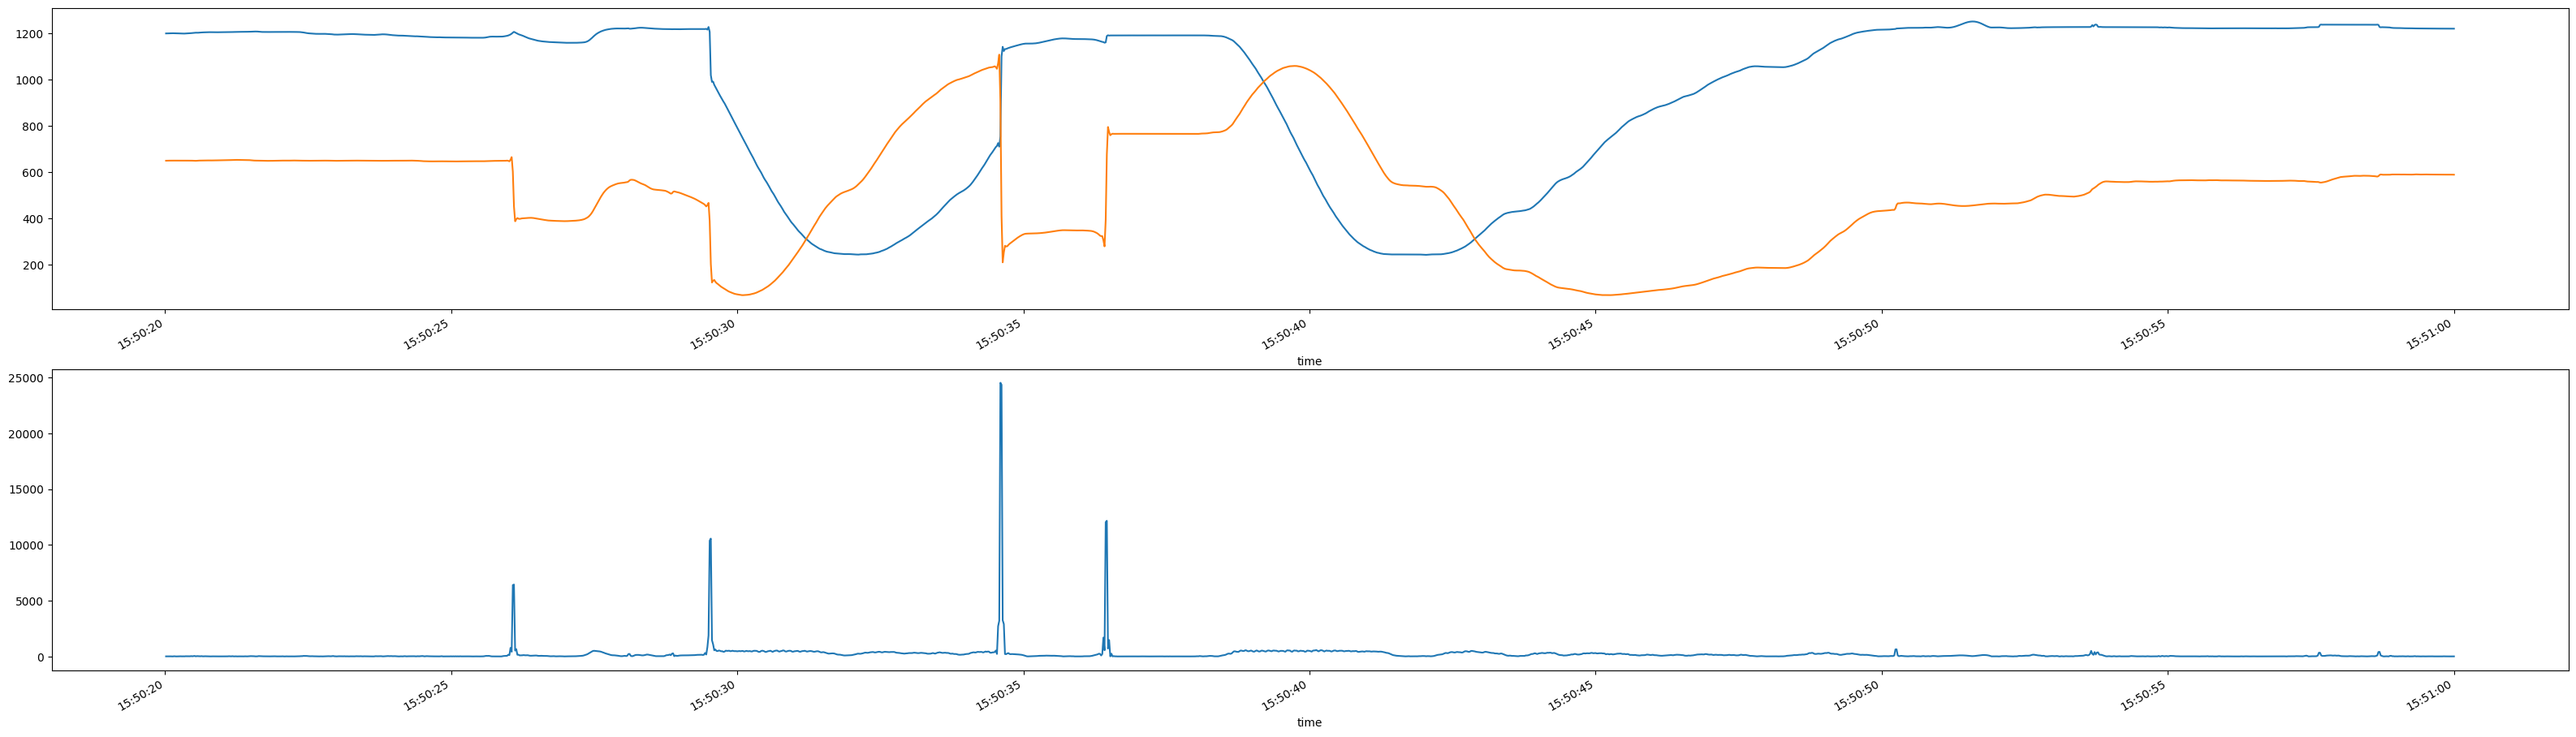

In [27]:
sub_start, sub_end = pd.Timestamp("2022-03-15 15:50:20"), pd.Timestamp("2022-03-15 15:51:00")
mouse_pos_sub = mouse_pos[sub_start:sub_end]
fig, axs = plt.subplots(2,1, figsize = (40,12))
mouse_pos_sub.smoothed_position_x.plot(ax = axs[0])
mouse_pos_sub.smoothed_position_y.plot(ax = axs[0])
mouse_pos_sub.smoothed_speed.plot(ax = axs[1])

plt.show()

In [25]:
# Example of exporting videos
sub_start, sub_end = pd.Timestamp("2022-03-15 15:50:20"), pd.Timestamp("2022-03-15 15:51:00")
video_metadata = api.load(root, exp02.CameraTop.Video, start=sub_start, end=sub_end)
video_metadata.index = video_metadata.index.round("20L")  # round timestamps to nearest 20 ms
frames = video.frames(video_metadata)  # get actual frames based on vid metadata
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
vid = cv2.VideoWriter("videos/session0_mouse_foraging.mp4", fourcc=fourcc, fps=50, frameSize=(1440, 1080))  # will save to current dir
for f in frames:  # write out frames to vid, frame-by-frame
    vid.write(f)
vid.release()

## Session 1

In [28]:
for session, i in zip(list(short_sessions.itertuples()), range(len(short_sessions))):
    if i == 1:
        print(session.id)
        title = 'ShortSession'+str(i)
        start, end = session.enter, session.exit
        print(start)
        mouse_pos = api.load(root, exp02.CameraTop.Position, start=start, end=end)
        
        temp_df = mouse_pos.dropna(subset=['x', 'y'])
        first_valid_index = temp_df.index[0]
        last_valid_index = temp_df.index[-1]
        mouse_pos = mouse_pos.loc[first_valid_index:last_valid_index]


        smoothRes = np.load(title+'smoothRes.npz')
        mouse_pos['smoothed_position_x'] = pd.Series(smoothRes['xnN'][0][0], index=mouse_pos.index)
        mouse_pos['smoothed_position_y'] = pd.Series(smoothRes['xnN'][3][0], index=mouse_pos.index)
        mouse_pos['smoothed_velocity_x'] = pd.Series(smoothRes['xnN'][1][0], index=mouse_pos.index)
        mouse_pos['smoothed_velocity_y'] = pd.Series(smoothRes['xnN'][4][0], index=mouse_pos.index)
        mouse_pos['smoothed_acceleration_x'] = pd.Series(smoothRes['xnN'][2][0], index=mouse_pos.index)
        mouse_pos['smoothed_acceleration_y'] = pd.Series(smoothRes['xnN'][5][0], index=mouse_pos.index)

        x_vel, y_vel = mouse_pos['smoothed_velocity_x'], mouse_pos['smoothed_velocity_y']
        vel = np.sqrt(x_vel**2 + y_vel**2)
        mouse_pos['smoothed_speed'] = pd.Series(vel)
            
        x_acc, y_acc = mouse_pos['smoothed_acceleration_x'], mouse_pos['smoothed_acceleration_y']
        acc = np.sqrt(x_acc**2 + y_acc**2)
        mouse_pos['smoothed_acceleration'] = pd.Series(acc)

BAA-1101818
2022-06-21 10:27:42.615139961


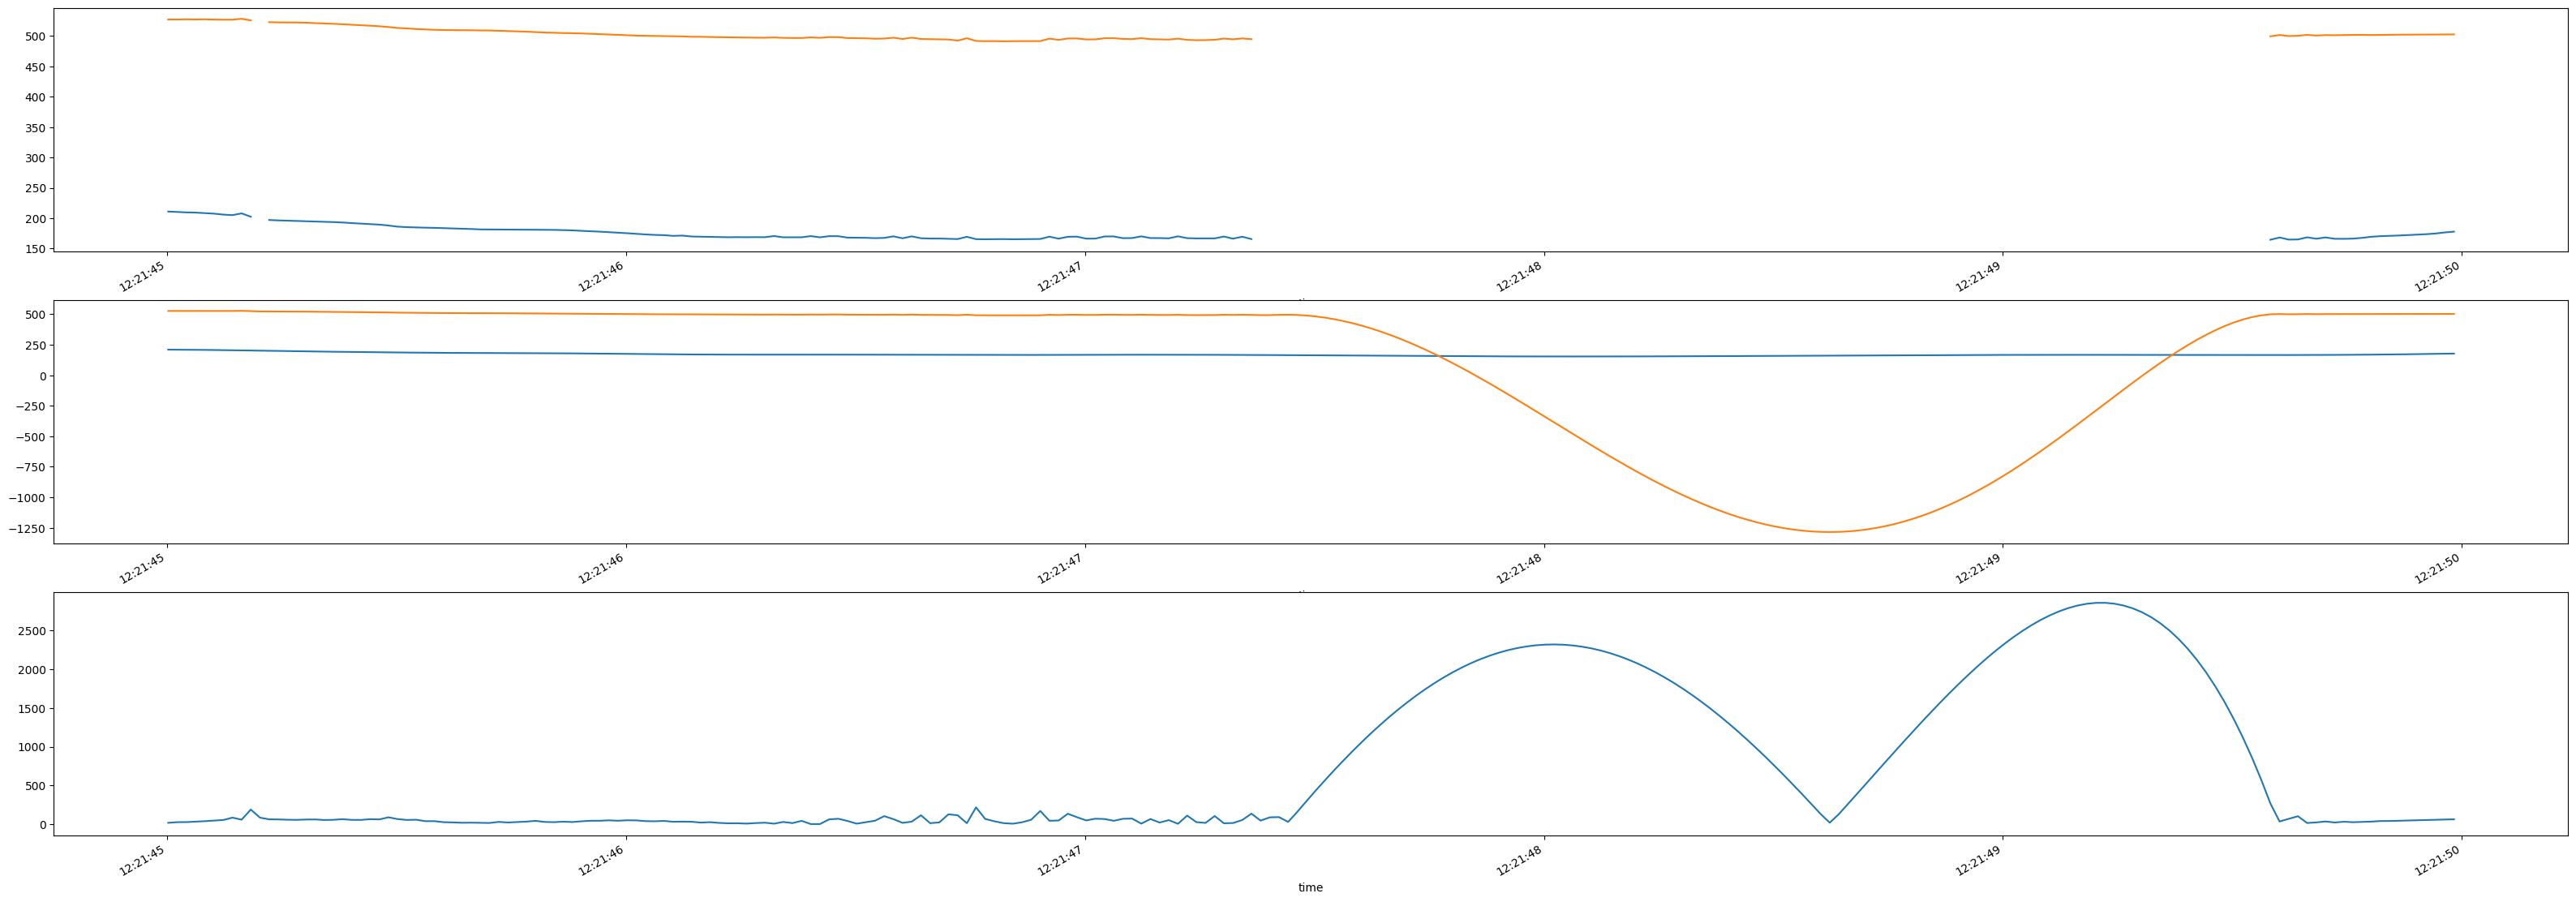

In [36]:
sub_start, sub_end = pd.Timestamp("2022-06-21 12:21:45"), pd.Timestamp("2022-06-21 12:21:50")
mouse_pos_sub = mouse_pos[sub_start:sub_end]
fig, axs = plt.subplots(3,1, figsize = (40,15))
mouse_pos_sub.x.plot(ax = axs[0])
mouse_pos_sub.y.plot(ax = axs[0])
mouse_pos_sub.smoothed_position_x.plot(ax = axs[1])
mouse_pos_sub.smoothed_position_y.plot(ax = axs[1])
mouse_pos_sub.smoothed_speed.plot(ax = axs[2])

plt.show()

In [35]:
# Example of exporting videos
video_metadata = api.load(root, exp02.CameraTop.Video, start=sub_start, end=sub_end)
video_metadata.index = video_metadata.index.round("20L")  # round timestamps to nearest 20 ms
frames = video.frames(video_metadata)  # get actual frames based on vid metadata
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
vid = cv2.VideoWriter("videos/" + title + "mouse_foraging.mp4", fourcc=fourcc, fps=50, frameSize=(1440, 1080))  # will save to current dir
for f in frames:  # write out frames to vid, frame-by-frame
    vid.write(f)
vid.release()

## Session 2

In [37]:
for session, i in zip(list(short_sessions.itertuples()), range(len(short_sessions))):
    if i == 2:
        print(session.id)
        title = 'ShortSession'+str(i)
        start, end = session.enter, session.exit
        print(start)
        mouse_pos = api.load(root, exp02.CameraTop.Position, start=start, end=end)
        
        temp_df = mouse_pos.dropna(subset=['x', 'y'])
        first_valid_index = temp_df.index[0]
        last_valid_index = temp_df.index[-1]
        mouse_pos = mouse_pos.loc[first_valid_index:last_valid_index]


        smoothRes = np.load(title+'smoothRes.npz')
        mouse_pos['smoothed_position_x'] = pd.Series(smoothRes['xnN'][0][0], index=mouse_pos.index)
        mouse_pos['smoothed_position_y'] = pd.Series(smoothRes['xnN'][3][0], index=mouse_pos.index)
        mouse_pos['smoothed_velocity_x'] = pd.Series(smoothRes['xnN'][1][0], index=mouse_pos.index)
        mouse_pos['smoothed_velocity_y'] = pd.Series(smoothRes['xnN'][4][0], index=mouse_pos.index)
        mouse_pos['smoothed_acceleration_x'] = pd.Series(smoothRes['xnN'][2][0], index=mouse_pos.index)
        mouse_pos['smoothed_acceleration_y'] = pd.Series(smoothRes['xnN'][5][0], index=mouse_pos.index)

        x_vel, y_vel = mouse_pos['smoothed_velocity_x'], mouse_pos['smoothed_velocity_y']
        vel = np.sqrt(x_vel**2 + y_vel**2)
        mouse_pos['smoothed_speed'] = pd.Series(vel)
            
        x_acc, y_acc = mouse_pos['smoothed_acceleration_x'], mouse_pos['smoothed_acceleration_y']
        acc = np.sqrt(x_acc**2 + y_acc**2)
        mouse_pos['smoothed_acceleration'] = pd.Series(acc)

BAA-1101819
2022-06-21 13:28:10.593659878


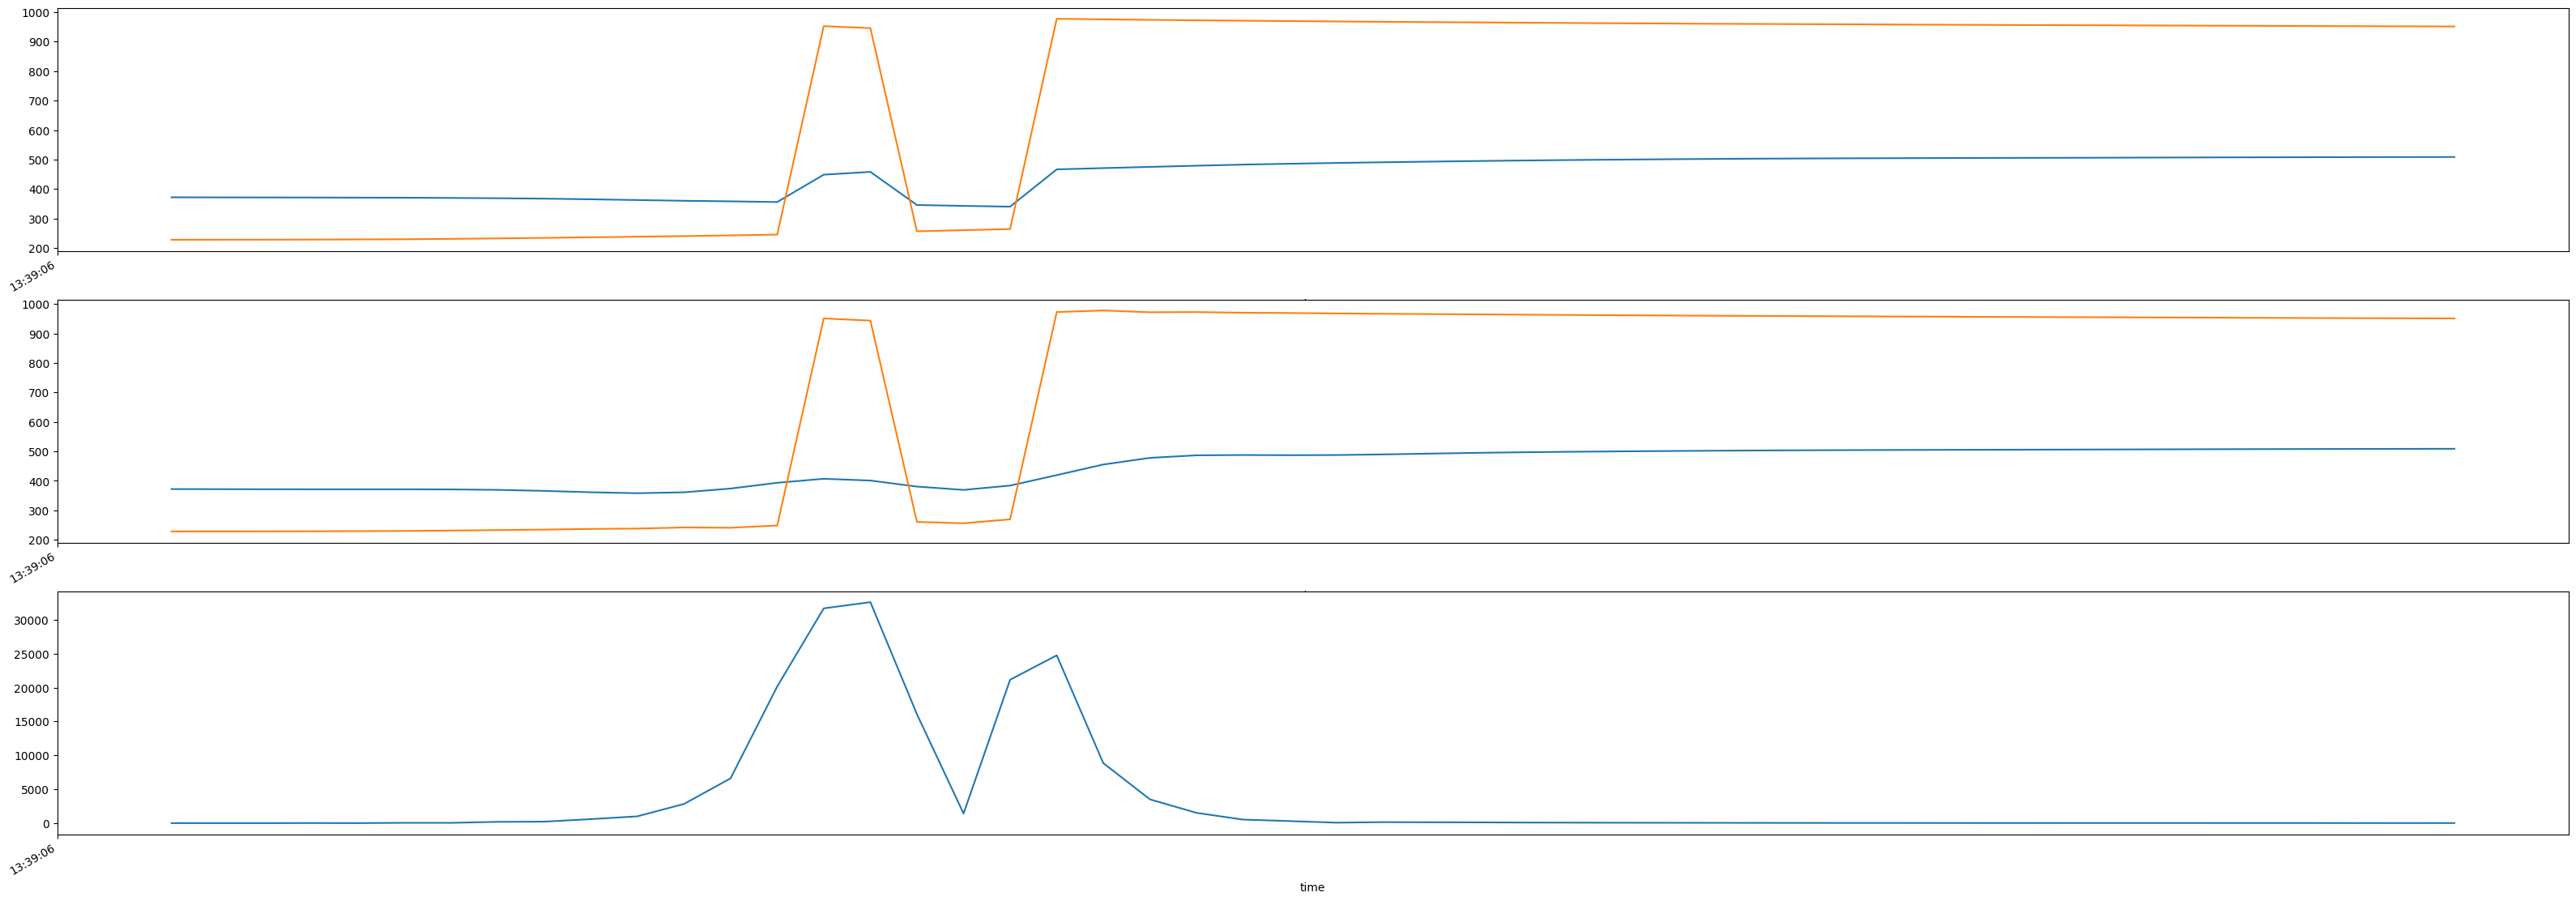

In [54]:
sub_start, sub_end = pd.Timestamp("2022-06-21 13:39:07"), pd.Timestamp("2022-06-21 13:39:08")
mouse_pos_sub = mouse_pos[sub_start:sub_end]
fig, axs = plt.subplots(3,1, figsize = (40,15))
mouse_pos_sub.x.plot(ax = axs[0])
mouse_pos_sub.y.plot(ax = axs[0])
mouse_pos_sub.smoothed_position_x.plot(ax = axs[1])
mouse_pos_sub.smoothed_position_y.plot(ax = axs[1])
mouse_pos_sub.smoothed_speed.plot(ax = axs[2])

plt.show()

In [55]:
# Example of exporting videos
video_metadata = api.load(root, exp02.CameraTop.Video, start=sub_start, end=sub_end)
video_metadata.index = video_metadata.index.round("20L")  # round timestamps to nearest 20 ms
frames = video.frames(video_metadata)  # get actual frames based on vid metadata
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
vid = cv2.VideoWriter("videos/" + title + "mouse_foraging.mp4", fourcc=fourcc, fps=50, frameSize=(1440, 1080))  # will save to current dir
for f in frames:  # write out frames to vid, frame-by-frame
    vid.write(f)
vid.release()

## Session 4

In [7]:
for session, i in zip(list(short_sessions.itertuples()), range(len(short_sessions))):
    if i == 4:
        print(session.id)
        title = 'ShortSession'+str(i)
        start, end = session.enter, session.exit
        print(start)
        mouse_pos = api.load(root, exp02.CameraTop.Position, start=start, end=end)
        
        temp_df = mouse_pos.dropna(subset=['x', 'y'])
        first_valid_index = temp_df.index[0]
        last_valid_index = temp_df.index[-1]
        mouse_pos = mouse_pos.loc[first_valid_index:last_valid_index]


        smoothRes = np.load(title+'smoothRes.npz')
        mouse_pos['smoothed_position_x'] = pd.Series(smoothRes['xnN'][0][0], index=mouse_pos.index)
        mouse_pos['smoothed_position_y'] = pd.Series(smoothRes['xnN'][3][0], index=mouse_pos.index)
        mouse_pos['smoothed_velocity_x'] = pd.Series(smoothRes['xnN'][1][0], index=mouse_pos.index)
        mouse_pos['smoothed_velocity_y'] = pd.Series(smoothRes['xnN'][4][0], index=mouse_pos.index)
        mouse_pos['smoothed_acceleration_x'] = pd.Series(smoothRes['xnN'][2][0], index=mouse_pos.index)
        mouse_pos['smoothed_acceleration_y'] = pd.Series(smoothRes['xnN'][5][0], index=mouse_pos.index)

        x_vel, y_vel = mouse_pos['smoothed_velocity_x'], mouse_pos['smoothed_velocity_y']
        vel = np.sqrt(x_vel**2 + y_vel**2)
        mouse_pos['smoothed_speed'] = pd.Series(vel)
            
        x_acc, y_acc = mouse_pos['smoothed_acceleration_x'], mouse_pos['smoothed_acceleration_y']
        acc = np.sqrt(x_acc**2 + y_acc**2)
        mouse_pos['smoothed_acceleration'] = pd.Series(acc)

BAA-1101818
2022-06-24 09:32:37.183360100


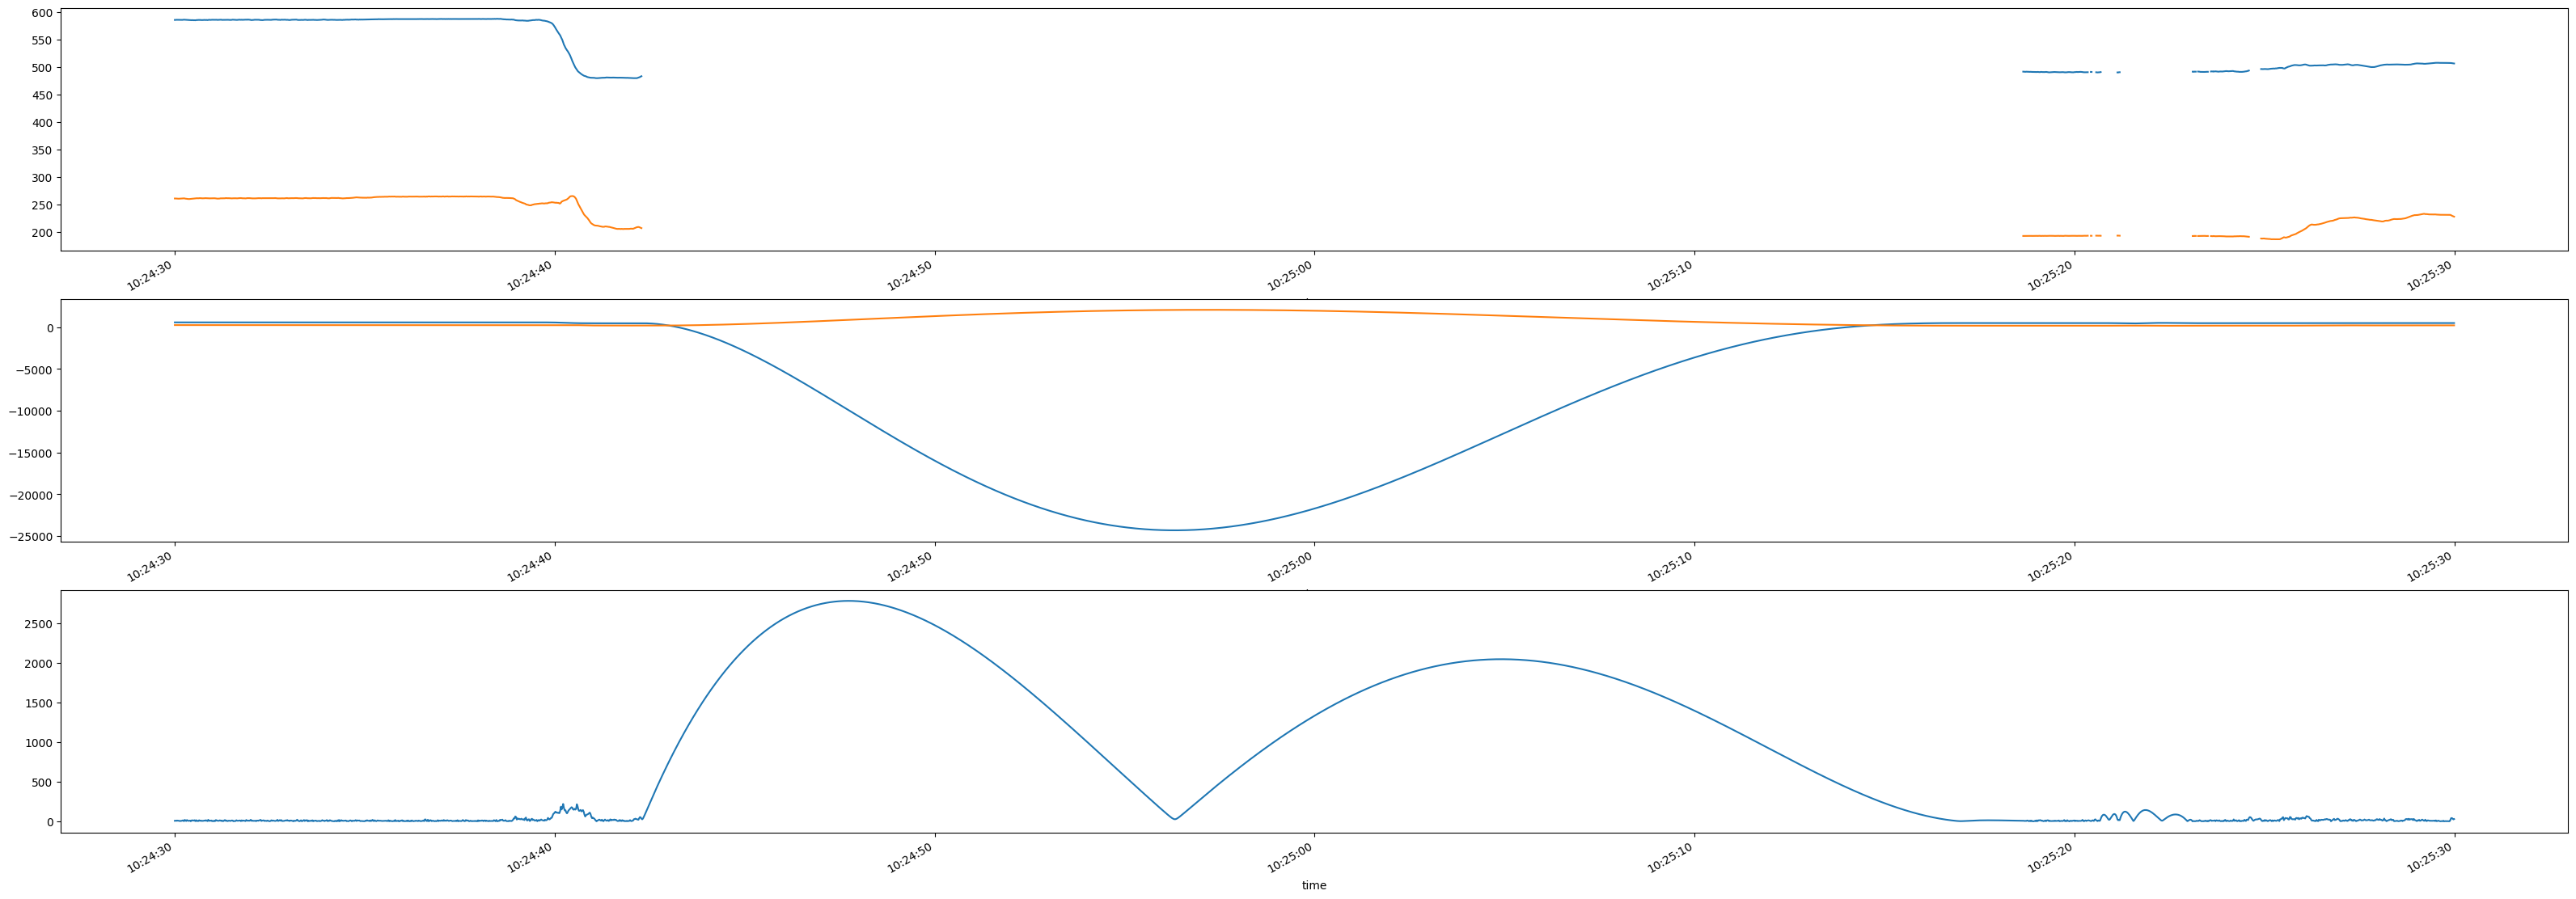

In [12]:
sub_start, sub_end = pd.Timestamp("2022-06-24 10:24:30"), pd.Timestamp("2022-06-24 10:25:30")
mouse_pos_sub = mouse_pos[sub_start:sub_end]
fig, axs = plt.subplots(3,1, figsize = (40,15))
mouse_pos_sub.x.plot(ax = axs[0])
mouse_pos_sub.y.plot(ax = axs[0])
mouse_pos_sub.smoothed_position_x.plot(ax = axs[1])
mouse_pos_sub.smoothed_position_y.plot(ax = axs[1])
mouse_pos_sub.smoothed_speed.plot(ax = axs[2])

plt.show()

In [13]:
# Example of exporting videos
video_metadata = api.load(root, exp02.CameraTop.Video, start=sub_start, end=sub_end)
video_metadata.index = video_metadata.index.round("20L")  # round timestamps to nearest 20 ms
frames = video.frames(video_metadata)  # get actual frames based on vid metadata
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
vid = cv2.VideoWriter("videos/" + title + "mouse_foraging.mp4", fourcc=fourcc, fps=50, frameSize=(1440, 1080))  # will save to current dir
for f in frames:  # write out frames to vid, frame-by-frame
    vid.write(f)
vid.release()

## Session 5

In [14]:
for session, i in zip(list(short_sessions.itertuples()), range(len(short_sessions))):
    if i == 5:
        print(session.id)
        title = 'ShortSession'+str(i)
        start, end = session.enter, session.exit
        print(start)
        mouse_pos = api.load(root, exp02.CameraTop.Position, start=start, end=end)
        
        temp_df = mouse_pos.dropna(subset=['x', 'y'])
        first_valid_index = temp_df.index[0]
        last_valid_index = temp_df.index[-1]
        mouse_pos = mouse_pos.loc[first_valid_index:last_valid_index]


        smoothRes = np.load(title+'smoothRes.npz')
        mouse_pos['smoothed_position_x'] = pd.Series(smoothRes['xnN'][0][0], index=mouse_pos.index)
        mouse_pos['smoothed_position_y'] = pd.Series(smoothRes['xnN'][3][0], index=mouse_pos.index)
        mouse_pos['smoothed_velocity_x'] = pd.Series(smoothRes['xnN'][1][0], index=mouse_pos.index)
        mouse_pos['smoothed_velocity_y'] = pd.Series(smoothRes['xnN'][4][0], index=mouse_pos.index)
        mouse_pos['smoothed_acceleration_x'] = pd.Series(smoothRes['xnN'][2][0], index=mouse_pos.index)
        mouse_pos['smoothed_acceleration_y'] = pd.Series(smoothRes['xnN'][5][0], index=mouse_pos.index)

        x_vel, y_vel = mouse_pos['smoothed_velocity_x'], mouse_pos['smoothed_velocity_y']
        vel = np.sqrt(x_vel**2 + y_vel**2)
        mouse_pos['smoothed_speed'] = pd.Series(vel)
            
        x_acc, y_acc = mouse_pos['smoothed_acceleration_x'], mouse_pos['smoothed_acceleration_y']
        acc = np.sqrt(x_acc**2 + y_acc**2)
        mouse_pos['smoothed_acceleration'] = pd.Series(acc)

BAA-1101823
2022-07-14 12:53:15.740799904


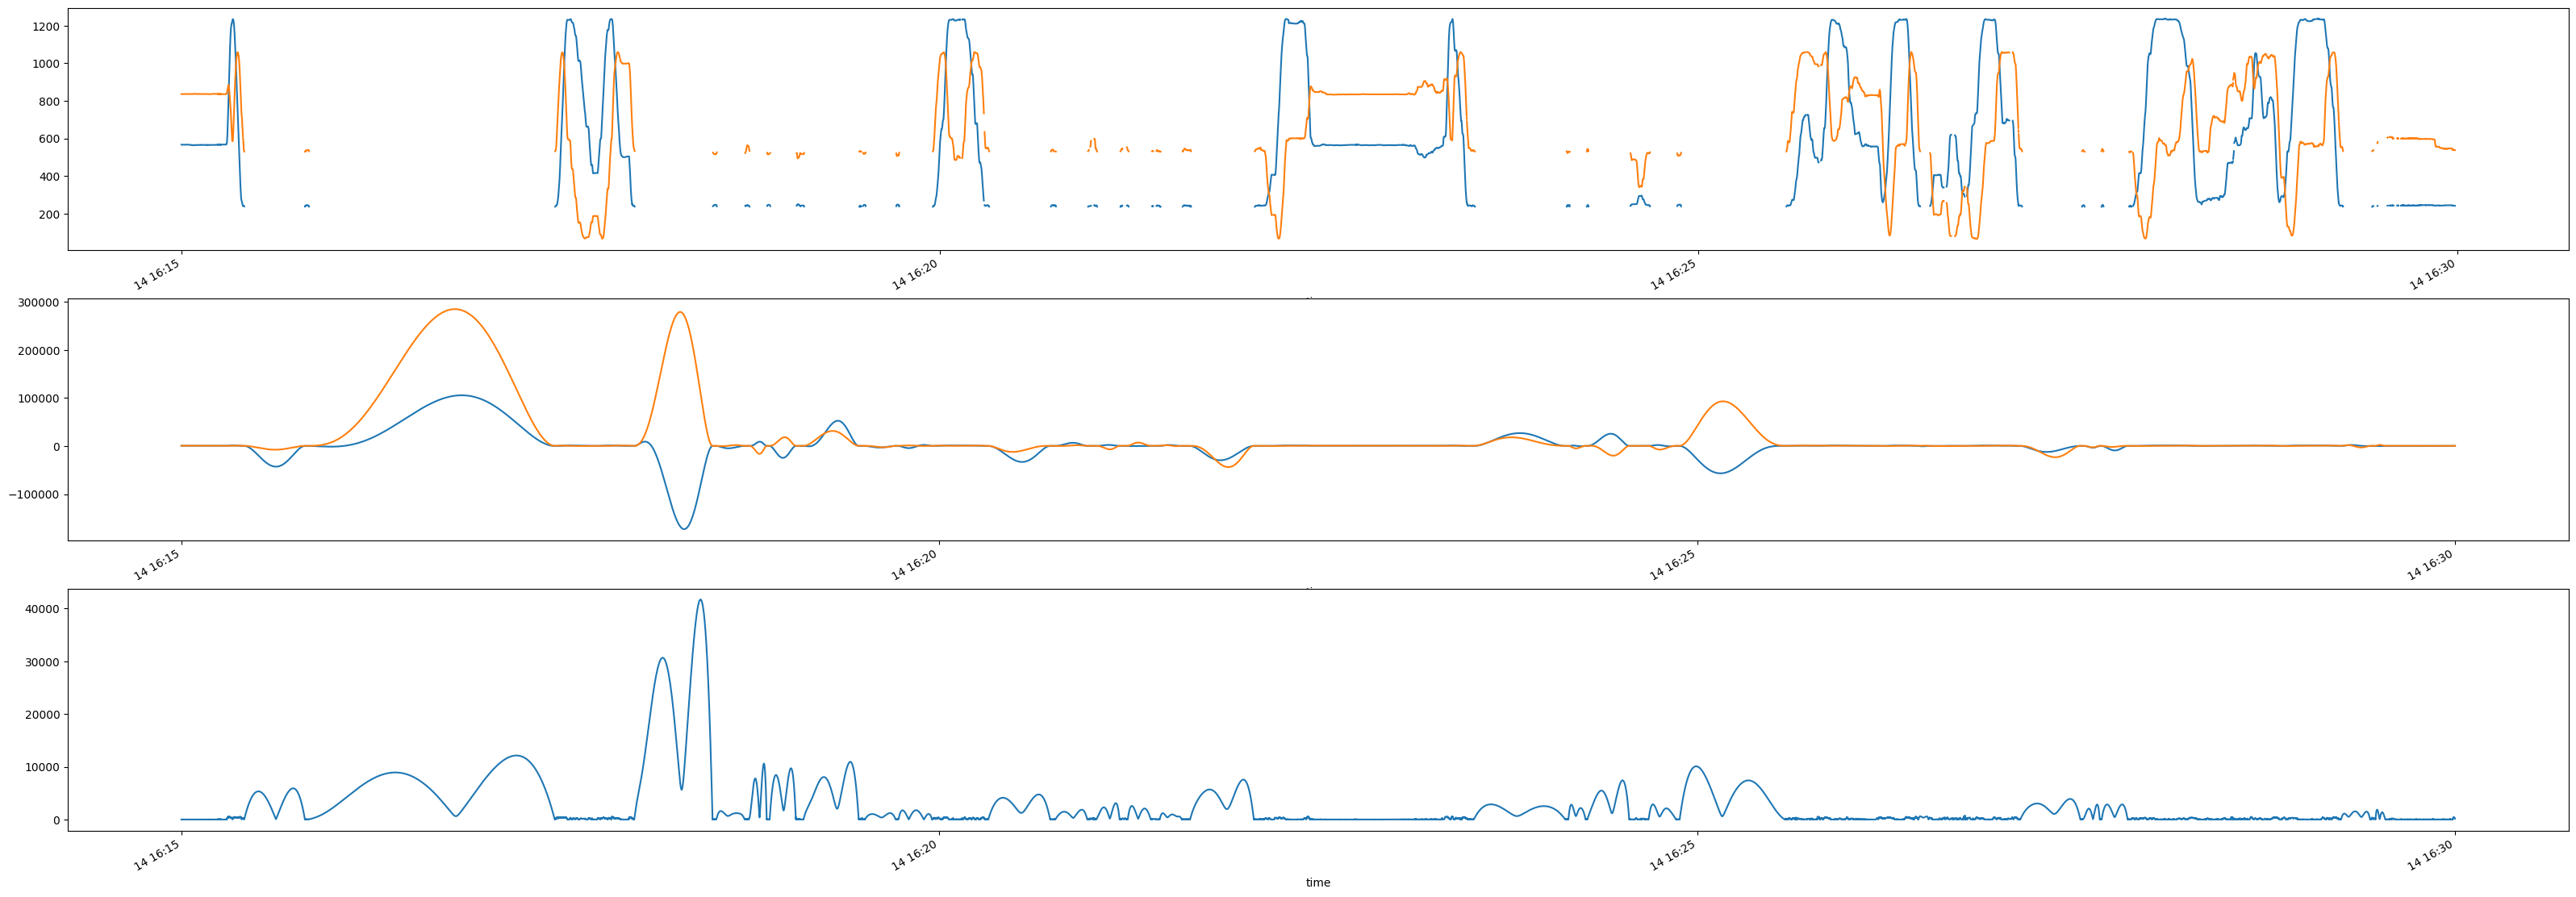

In [23]:
sub_start, sub_end = pd.Timestamp("2022-07-14 16:15:00"), pd.Timestamp("2022-07-14 16:30:00")
mouse_pos_sub = mouse_pos[sub_start:sub_end]
fig, axs = plt.subplots(3,1, figsize = (40,15))
mouse_pos_sub.x.plot(ax = axs[0])
mouse_pos_sub.y.plot(ax = axs[0])
mouse_pos_sub.smoothed_position_x.plot(ax = axs[1])
mouse_pos_sub.smoothed_position_y.plot(ax = axs[1])
mouse_pos_sub.smoothed_speed.plot(ax = axs[2])

plt.show()

In [24]:
# Example of exporting videos
video_metadata = api.load(root, exp02.CameraTop.Video, start=sub_start, end=sub_end)
video_metadata.index = video_metadata.index.round("20L")  # round timestamps to nearest 20 ms
frames = video.frames(video_metadata)  # get actual frames based on vid metadata
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
vid = cv2.VideoWriter("videos/" + title + "mouse_foraging.mp4", fourcc=fourcc, fps=50, frameSize=(1440, 1080))  # will save to current dir
for f in frames:  # write out frames to vid, frame-by-frame
    vid.write(f)
vid.release()